In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

# import data
def load_data(file_name):
    # load from XLSX file
    dataset = pd.read_excel(io=file_name)
    
    # unpivot from wide to long format
    dataset = dataset.melt(id_vars='Year', var_name='Month', value_name='Rate')
    
    from pandas.tseries.offsets import MonthEnd
    
    # assign last day of month
    dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)
    
    # order ascending data values
    dataset = dataset.sort_values(by='Date', ascending=True)
    
    # drop unnecessary columns
    dataset = dataset.drop(['Year', 'Month'], axis=1)
    
    # set date column as index
    dataset.set_index('Date', inplace=True)
    
    # drop NaN rows
    dataset.dropna(subset=['Rate'], inplace=True)
    
    return dataset
    
df = load_data(file_name='inflation_ratings.xlsx')
df.to_csv("date-wise-data.csv")
df

,Rate
Date,
1997-01-31,17.7
1997-02-28,17.4
1997-03-31,16.5
1997-04-30,15.3
1997-05-31,14.4
...,...
2021-07-31,4.7
2021-08-31,5.0
2021-09-30,5.6


In [12]:
df = pd.read_csv("/Users/damodargupta/Desktop/EPICS-PROJECT/date-wise-data.csv")
df["Date"] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index(["Date"])
df.to_csv("date-wise-data.csv")
df

,Rate
Date,
1997-01-31,17.7
1997-02-28,17.4
1997-03-31,16.5
1997-04-30,15.3
1997-05-31,14.4
...,...
2021-07-31,4.7
2021-08-31,5.0
2021-09-30,5.6


In [9]:
def filter_by_date(dataframe, start_date, end_date):
    dataframe = pd.read_csv("/Users/damodargupta/Desktop/EPICS-PROJECT/date-wise-data.csv")
    # Convert 'Date' column to datetime if not already done
    if dataframe['Date'].dtype == 'object':
        dataframe['Date'] = pd.to_datetime(dataframe['Date'])
    # Filter the dataframe for the given range of dates
    filtered_df = dataframe[(dataframe['Date'] >= start_date) & (dataframe['Date'] <= end_date)]
    return filtered_df['Rate']

# Test the function with a sample date range
sample_start_date = '1997-01-01'
sample_end_date = '1997-12-31'
sample_filtered_rates = filter_by_date(df, sample_start_date, sample_end_date)
print(sample_filtered_rates.head())

0    17.7
1    17.4
2    16.5
3    15.3
4    14.4
Name: Rate, dtype: float64


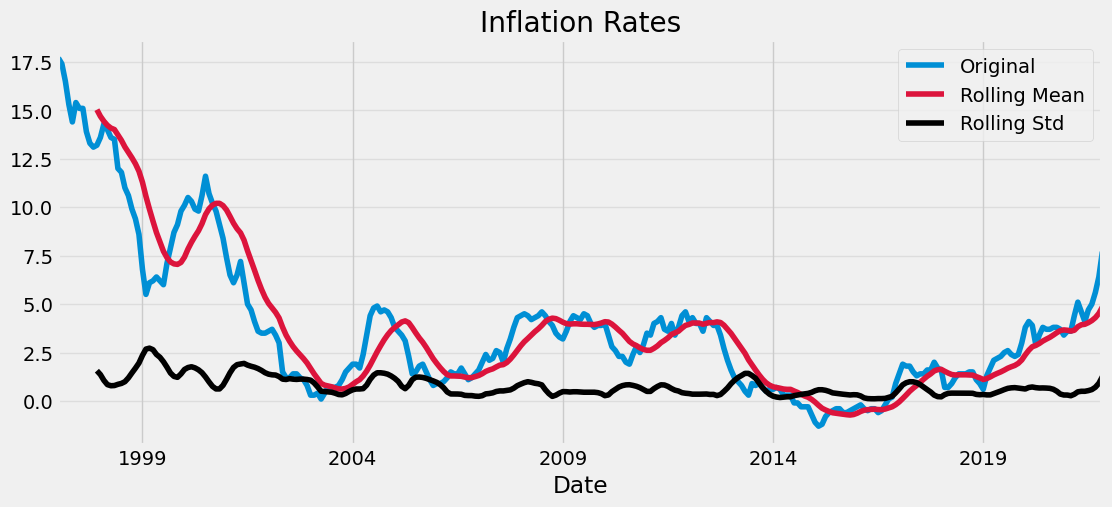

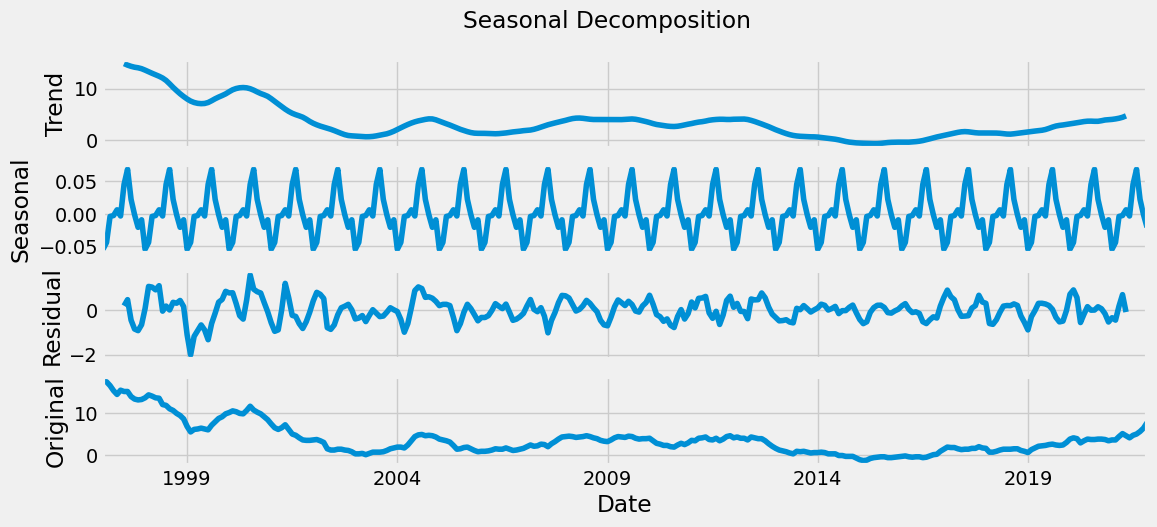

In [9]:
# visualize target data
def plot_time_series(series):
    mean_rolling = series.rolling(window=12).mean()
    std_rolling = series.rolling(window=12).std()
    
    # plot inflation rates
    series.plot(figsize=(12, 5), label='Original')
    mean_rolling.plot(color='crimson', label='Rolling Mean')
    std_rolling.plot(color='black', label='Rolling Std')
    plt.title('Inflation Rates')
    plt.grid(axis='y', alpha=0.5)
    plt.legend(loc='best')
    plt.show()
    
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    # plot decomposition components
    decomp = seasonal_decompose(series, model='additive')
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12, 5))
    fig.suptitle('Seasonal Decomposition')
    
    decomp.trend.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Trend')
    
    decomp.seasonal.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Seasonal')
    
    decomp.resid.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Residual')
    
    decomp.observed.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Original')
    plt.show()

plot_time_series(df['Rate'])

In [10]:
# ADF statistical test
def adf_test(series):
    from statsmodels.tsa.stattools import adfuller
    
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: {:.6f}'.format(result[0]))
    print('2. P-value: {:.6f}'.format(result[1]))
    print('3. Used Lags: {}'.format(result[2]))
    print('4. Used Observations: {}'.format(result[3]))
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.6f}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')
    return

# run function
adf_test(df['Rate'])

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic: -3.841632
2. P-value: 0.002509
3. Used Lags: 13
4. Used Observations: 285
5. Critical Values:
	1%: -3.453505
	5%: -2.871735
	10%: -2.572202

Strong evidence against the null hypothesis (H0), reject the null hypothesis.        Data has no unit root and is stationary.


In [11]:
# perform data transformation
# series: must be a pandas dataframe
def series_transformation(series):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import adfuller
    
    # 1st plot - data after transformation
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Transformed Series')
    ax1.plot(series)
    ax1.plot(series.rolling(window=12).mean(), color='crimson')
    ax1.plot(series.rolling(window=12).std(), color='black')
    
    # 2nd plot - partial autocorrelation plot
    ax2 = fig.add_subplot(1, 3, 2)
    plot_acf(series.dropna(), ax=ax2, lags=15, title='Autocorrelation')
    # plot 95% confidence intervals
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='gray')
    plt.xlabel('lags')

    # 3rd plot - partial autocorrelation plot
    ax3 = fig.add_subplot(1, 3, 3)
    plot_pacf(series.dropna(), ax=ax3, lags=15, title='Partial Autocorrelation')
    plt.axhline(y=-1.96/np.sqrt(len(series)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(series)), linestyle='--', color='gray')
    plt.xlabel('lags')

    plt.show()
    
    # ADF test
    result = adfuller(series.dropna(), regression='c', autolag='AIC')
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('P-value = {:.6f}, the series is likely stationary.'.format(result[1]))
    else:
        print('P-value = {:.6f}, the series is likely non-stationary.'.format(result[1]))
    return

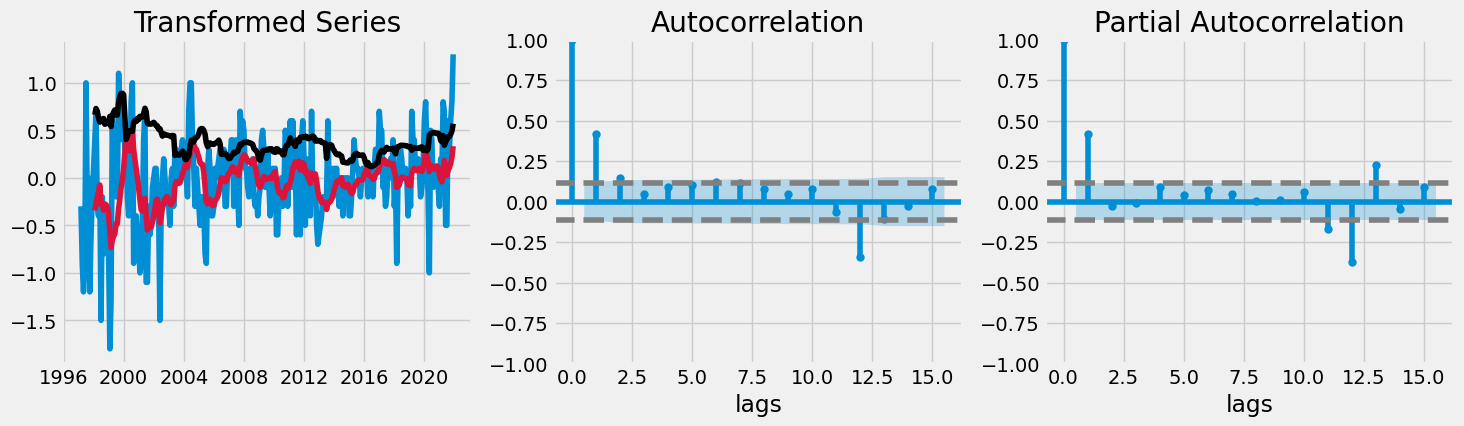

P-value = 0.002781, the series is likely stationary.


In [12]:
# first difference
series_transformation(df.diff())

The first difference time series shows less trend anymore. It looks to be more stationary. We will try further differencing.

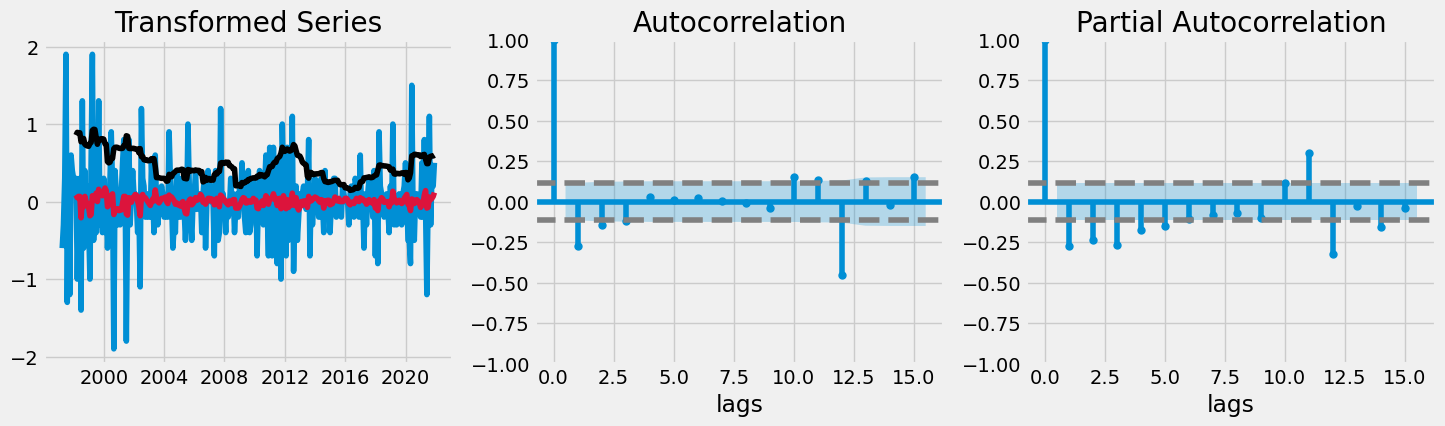

P-value = 0.000000, the series is likely stationary.


In [13]:
# second difference
series_transformation(df.diff().diff())

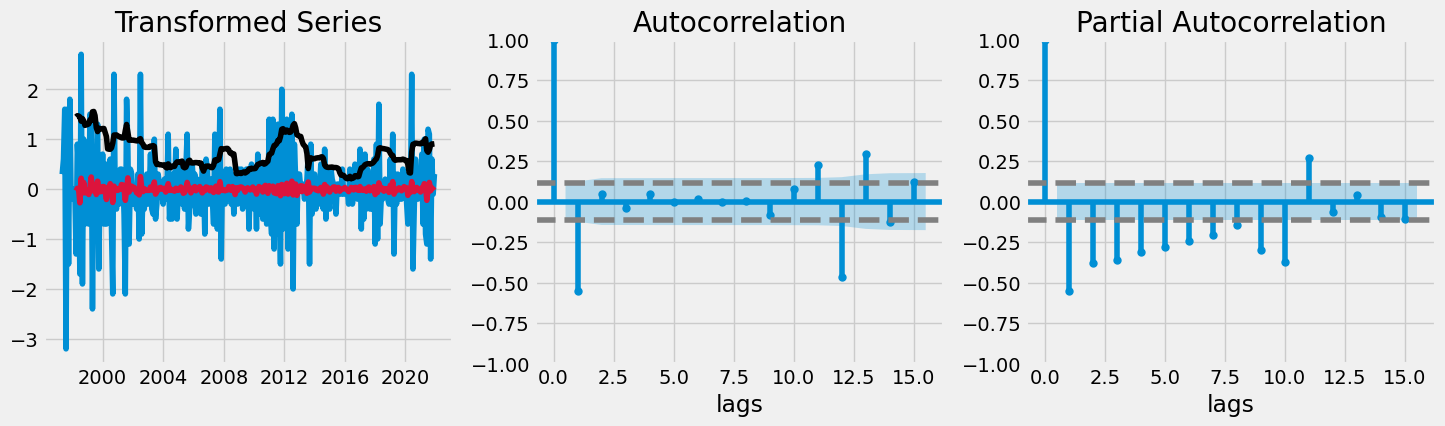

P-value = 0.000000, the series is likely stationary.


In [14]:
# third difference
series_transformation(df.diff().diff().diff())

In [15]:


print(df['Rate'].index.freq)

None


In [16]:
# find best orders and evaluate each combination for SARIMAX model
# series: must be a pandas dataframe
def find_optimal_orders(series, verbose=True):
    # filter out harmless warnings
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    import time
    
    # start timer
    start_time = time.time()
    
    ######### list of possible combinations
    order_list = []
    for p in range(0, 3):
            for d in range(0, 2):
                for q in range(0, 3):
                    order_list.append((p, d, q))
    
    ######### initialize variables
    m = 12
    trend_pdq = order_list
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in order_list]
    min_aic = float('inf')
    best_params = {'order': None, 'seasonal_order': None}
    
    ######### loop through every possible configuration and print results
    print('Expected Fits: {}'.format(len(trend_pdq) * len(trend_pdq)))
    print('========== SARIMAX Results ==========\n')
    count = 0
    for param in trend_pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(endog=series, order=param, seasonal_order=param_seasonal, freq='M', exog=None,
                                enforce_stationarity=False, enforce_invertibility=False)
                model_fit = model.fit()
                
                if verbose:
                    count += 1
                    print('{}. SARIMAX{}{}[{}],\tAIC = {:.6f},\tBIC = {:.6f}'.format(count, param,
                                                        param_seasonal[:-1], m, model_fit.aic, model_fit.bic))
                    
                if model_fit.aic < min_aic:
                    min_aic = model_fit.aic
                    best_params['order'] = param
                    best_params['seasonal_order'] = param_seasonal
                    line = count
            except:
                print('Error while fitting model')
                continue
    print('\nBest order: {}{}[{}] with AIC = {:.6f} at line {}'.format(best_params['order'],
                                                             best_params['seasonal_order'][:-1], m, min_aic, line))
    
    # stop timer and display execution time
    diff = time.time() - start_time
    print('\n(Total time of execution: {:.0f} min {:.2f} s)'.format(diff%3600//60, diff%60))

In [17]:
# display results
find_optimal_orders(df['Rate'], verbose=True)

Expected Fits: 324
========== SARIMAX Results ==========

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06847D+00    |proj g|=  6.22887D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      5      1     0     0   8.047D-08   3.068D+00
  F =   3.0681841558617187     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
1. SARIMAX(0, 0, 0)(0, 0, 0)[12],	AIC = 1836.774125,	BIC = 1840.471219
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.07033D+00    |proj g|=  2.47706D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   7.350D-06   2.070D+00
  F =   2.0703244744843996     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
3. SARIMAX(0, 0, 0)(0, 0, 2)[12],	AIC = 1244.054036,	BIC = 1254.893420
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22821D+00    |proj g|=  1.39424D-02

           * * *

Tit   = total number of iterations
Tnf   =

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


5. SARIMAX(0, 0, 0)(0, 1, 1)[12],	AIC = 1263.498298,	BIC = 1270.724554
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24089D+00    |proj g|=  1.16990D+00

At iterate    5    f=  1.91486D+00    |proj g|=  7.41158D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   5.803D-07   1.915D+00
  F =   1.9147795836180075     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
6. SARIMAX(0, 0, 0)(0, 1, 2)[12],	AIC = 1151.038191,	BIC = 11

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34397D+00    |proj g|=  1.30019D+00

At iterate    5    f=  1.96532D+00    |proj g|=  4.25828D-02


 This problem is unconstrained.



At iterate   10    f=  1.96102D+00    |proj g|=  7.66438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   6.896D-07   1.961D+00
  F =   1.9610142022465880     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
9. SARIMAX(0, 0, 0)(1, 0, 2)[12],	AIC = 1180.686493,	BIC = 1195.139005
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12715D+00    |proj g|=  4.88907D-06

           * * *

Tit   = total number of iterations
Tnf   =

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.99234D+00    |proj g|=  4.90713D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   6.434D-06   1.992D+00
  F =   1.9923411115748899     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
11. SARIMAX(0, 0, 0)(1, 1, 1)[12],	AIC = 1197.419985,	BIC = 1208.259369
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17300D+00    |proj g|=  9.71878D-01


 This problem is unconstrained.



At iterate    5    f=  1.91712D+00    |proj g|=  2.09506D-02

At iterate   10    f=  1.91583D+00    |proj g|=  9.84889D-02

At iterate   15    f=  1.90144D+00    |proj g|=  2.40682D-01

At iterate   20    f=  1.88998D+00    |proj g|=  1.94122D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     32      1     0     0   1.726D-05   1.890D+00
  F =   1.8899826526027308     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
12. SARIMAX(0, 0, 0)(1, 1, 2)[12],	AIC = 1138.209626,	BIC = 1152.483004
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.90400D+00    |proj g|=  5.48967D-02

At iterate   10    f=  1.89752D+00    |proj g|=  2.57683D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   1.796D-06   1.898D+00
  F =   1.8975132683786351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
14. SARIMAX(0, 0, 0)(2, 0, 1)[12],	AIC = 1142.712934,	BIC = 1157.180019
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33853D+00    |proj g|=  1.32840D+0

 This problem is unconstrained.



At iterate    5    f=  1.93670D+00    |proj g|=  5.17761D-02

At iterate   10    f=  1.90834D+00    |proj g|=  1.42988D-01

At iterate   15    f=  1.88814D+00    |proj g|=  2.28909D-02

At iterate   20    f=  1.88804D+00    |proj g|=  6.76924D-04

At iterate   25    f=  1.88804D+00    |proj g|=  5.31291D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   5.313D-06   1.888D+00
  F =   1.8880387007268815     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
15. SARIMAX(0, 0, 0)(2, 0, 2)[12],	AIC = 1139.047143,	BIC = 1157.112784
RUNNING THE L-BFGS-B CODE

           * *

 This problem is unconstrained.


16. SARIMAX(0, 0, 0)(2, 1, 0)[12],	AIC = 1151.021706,	BIC = 1161.738168
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27204D+00    |proj g|=  1.73231D+00

At iterate    5    f=  1.87243D+00    |proj g|=  7.33284D-02


 This problem is unconstrained.



At iterate   10    f=  1.83736D+00    |proj g|=  1.63265D-02

At iterate   15    f=  1.83714D+00    |proj g|=  6.75007D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     16      1     0     0   6.750D-06   1.837D+00
  F =   1.8371444935235526     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
17. SARIMAX(0, 0, 0)(2, 1, 1)[12],	AIC = 1106.612407,	BIC = 1120.901023
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99101D+00    |proj g|=  5.85112D-0

 This problem is unconstrained.



At iterate    5    f=  1.85146D+00    |proj g|=  4.74199D-02

At iterate   10    f=  1.83075D+00    |proj g|=  1.51905D-02

At iterate   15    f=  1.83018D+00    |proj g|=  1.21327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   2.139D-06   1.830D+00
  F =   1.8301777319538830     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
18. SARIMAX(0, 0, 0)(2, 1, 2)[12],	AIC = 1104.446284,	BIC = 1122.288006
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bound

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.90032D+00    |proj g|=  3.31794D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     21      1     0     0   5.480D-06   1.900D+00
  F =   1.9003223920965113     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
20. SARIMAX(0, 0, 1)(0, 0, 1)[12],	AIC = 1142.392790,	BIC = 1153.350258
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.58310D+00    |proj g|=  6.98489D-01


 This problem is unconstrained.



At iterate    5    f=  1.74080D+00    |proj g|=  2.43512D-01

At iterate   10    f=  1.67129D+00    |proj g|=  2.98755D-01

At iterate   15    f=  1.62937D+00    |proj g|=  3.15291D-01

At iterate   20    f=  1.58145D+00    |proj g|=  7.27293D-02

At iterate   25    f=  1.57872D+00    |proj g|=  3.80354D-03

At iterate   30    f=  1.57867D+00    |proj g|=  2.06297D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     47      1     0     0   2.457D-06   1.579D+00
  F =   1.5786693814487032     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
21. SARIMAX(0, 0, 1)(0, 0, 2)[12],	AIC = 952.044290

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.50990D+00    |proj g|=  9.57572D-02

At iterate   10    f=  1.50548D+00    |proj g|=  5.58147D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   3.799D-06   1.505D+00
  F =   1.5054780604855600     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
23. SARIMAX(0, 0, 1)(0, 1, 1)[12],	AIC = 906.275880,	BIC = 917.104296
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88521D+00    |proj g|=  5.49762D-01


 This problem is unconstrained.



At iterate    5    f=  1.38971D+00    |proj g|=  1.57872D-01

At iterate   10    f=  1.38122D+00    |proj g|=  1.09107D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   1.141D-05   1.381D+00
  F =   1.3812204955328518     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
24. SARIMAX(0, 0, 1)(0, 1, 2)[12],	AIC = 833.969856,	BIC = 848.227938
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66801D+00    |proj g|=  7.35205D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.63703D+00    |proj g|=  1.36125D-01

At iterate   15    f=  1.51343D+00    |proj g|=  8.65471D-01

At iterate   20    f=  1.47167D+00    |proj g|=  5.92715D-02

At iterate   25    f=  1.47099D+00    |proj g|=  1.78535D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     42      1     0     0   9.227D-06   1.471D+00
  F =   1.4709852019362342     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
26. SARIMAX(0, 0, 1)(1, 0, 1)[12],	AIC = 887.649151,	BIC = 902.259107
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =     

 This problem is unconstrained.



At iterate    5    f=  1.78876D+00    |proj g|=  7.98718D-01

At iterate   10    f=  1.42010D+00    |proj g|=  9.11886D-02

At iterate   15    f=  1.41368D+00    |proj g|=  6.47260D-03

At iterate   20    f=  1.41363D+00    |proj g|=  3.73421D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     34      1     0     0   2.889D-06   1.414D+00
  F =   1.4136313251376054     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
27. SARIMAX(0, 0, 1)(1, 0, 2)[12],	AIC = 855.351532,	BIC = 873.398891
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.57398D+00    |proj g|=  3.01122D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     20      1     0     0   3.022D-05   1.574D+00
  F =   1.5739778650764225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
28. SARIMAX(0, 0, 1)(1, 1, 0)[12],	AIC = 947.238763,	BIC = 958.089077
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09388D+00    |proj g|=  5.84334D-01

At iterate    5    f=  1.52352D+00    |proj g|=  7.07840D-02


 This problem is unconstrained.



At iterate    5    f=  1.40093D+00    |proj g|=  2.02080D-01

At iterate   10    f=  1.38257D+00    |proj g|=  1.76430D-03

At iterate   15    f=  1.38065D+00    |proj g|=  6.45031D-02

At iterate   20    f=  1.37928D+00    |proj g|=  3.85771D-02

At iterate   25    f=  1.37908D+00    |proj g|=  1.01457D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     38      1     0     0   7.138D-06   1.379D+00
  F =   1.3790752238669259     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
30. SARIMAX(0, 0, 1)(1, 1, 2)[12],	AIC = 834.686984,	BIC = 852.509586
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.


31. SARIMAX(0, 0, 1)(2, 0, 0)[12],	AIC = 861.186909,	BIC = 875.653993
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68898D+00    |proj g|=  6.83521D-01

At iterate    5    f=  1.80608D+00    |proj g|=  1.58609D+00

At iterate   10    f=  1.43495D+00    |proj g|=  1.66711D-01


 This problem is unconstrained.



At iterate   15    f=  1.42382D+00    |proj g|=  8.51018D-02

At iterate   20    f=  1.38430D+00    |proj g|=  1.49061D-01

At iterate   25    f=  1.37702D+00    |proj g|=  8.34264D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     43      1     0     0   1.608D-05   1.377D+00
  F =   1.3770195121743087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
32. SARIMAX(0, 0, 1)(2, 0, 1)[12],	AIC = 833.457668,	BIC = 851.541524


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55030D+00    |proj g|=  6.89923D-01

At iterate    5    f=  1.73468D+00    |proj g|=  8.22011D-01

At iterate   10    f=  1.42377D+00    |proj g|=  2.76928D-01

At iterate   15    f=  1.37808D+00    |proj g|=  8.84277D-02

At iterate   20    f=  1.35729D+00    |proj g|=  1.69811D-02

At iterate   25    f=  1.35725D+00    |proj g|=  1.55594D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     38      1     0     0   

 This problem is unconstrained.



At iterate   10    f=  1.39012D+00    |proj g|=  1.29855D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   1.147D-05   1.390D+00
  F =   1.3901195833336342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
34. SARIMAX(0, 0, 1)(2, 1, 0)[12],	AIC = 839.291511,	BIC = 853.580127
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96523D+00    |proj g|=  4.76949D-01


 This problem is unconstrained.



At iterate    5    f=  1.36599D+00    |proj g|=  1.41298D-01

At iterate   10    f=  1.34046D+00    |proj g|=  3.61322D-02

At iterate   15    f=  1.33928D+00    |proj g|=  2.52123D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   2.521D-05   1.339D+00
  F =   1.3392833267735860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
35. SARIMAX(0, 0, 1)(2, 1, 1)[12],	AIC = 810.891429,	BIC = 828.752200


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85964D+00    |proj g|=  5.78940D-01

At iterate    5    f=  1.35244D+00    |proj g|=  9.99862D-02

At iterate   10    f=  1.33089D+00    |proj g|=  8.69152D-02

At iterate   15    f=  1.32789D+00    |proj g|=  1.40215D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     25      1     0     0   7.110D-05   1.328D+00
  F =   1.3278944976390288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
36. SARI

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.49822D+00    |proj g|=  6.10097D-01

At iterate   10    f=  1.43168D+00    |proj g|=  1.11099D-01

At iterate   15    f=  1.43145D+00    |proj g|=  2.17087D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     35      1     0     0   4.426D-05   1.431D+00
  F =   1.4314472160762381     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
38. SARIMAX(0, 0, 2)(0, 0, 1)[12],	AIC = 864.005435,	BIC = 878.601332
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  1.30449D+00    |proj g|=  2.13639D-01

At iterate   10    f=  1.27480D+00    |proj g|=  2.19951D-02

At iterate   15    f=  1.22941D+00    |proj g|=  5.24899D-02

At iterate   20    f=  1.22911D+00    |proj g|=  5.44008D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     44      1     0     0   2.641D-05   1.229D+00
  F =   1.2291137707528845     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
39. SARIMAX(0, 0, 2)(0, 0, 2)[12],	AIC = 745.010035,	BIC = 763.039045
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =     

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   10    f=  1.33696D+00    |proj g|=  7.33279D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     60      2     0     0   1.004D-05   1.337D+00
  F =   1.3369453394810660     

ABNORMAL_TERMINATION_IN_LNSRCH                              
40. SARIMAX(0, 0, 2)(0, 1, 0)[12],	AIC = 805.493313,	BIC = 816.440236
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95449D+00    |proj g|=  4.98937D-01

At iterate    5    f=  1.19005D+00    |proj g|=  1.81499D-01

At iterate   10    f=  1.16149D+00    |proj g|=  4.82856D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     30      1     0     0   2.746D-04   1.161D+00
  F =   1.1614064244552273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
41. SARIMAX(0, 0, 2)(0, 1, 1)[12],	AIC = 702.521042,	BIC = 716.944250
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79297D+00    |proj g|=  5.65928D-01

At iterate    5    f=  1.12323D+00    |proj g|=  7.21815D-02

At iterate   10    f=  1.08517D+00    |proj g|=  2.10094D-01


 This problem is unconstrained.



At iterate   25    f=  1.20616D+00    |proj g|=  3.66838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     54      1     0     0   1.455D-04   1.206D+00
  F =   1.2061635555724288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
43. SARIMAX(0, 0, 2)(1, 0, 0)[12],	AIC = 729.285806,	BIC = 743.923735
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.69449D+00    |proj g|=  6.46084D-01

At iterate    5    f=  1.58108D+00    |proj g|=  1.82150D+00


 This problem is unconstrained.



At iterate   10    f=  1.18157D+00    |proj g|=  2.22880D-01

At iterate   15    f=  1.15961D+00    |proj g|=  5.73561D-02

At iterate   20    f=  1.15863D+00    |proj g|=  5.06094D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     41      1     0     0   3.399D-06   1.159D+00
  F =   1.1586285796344868     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
44. SARIMAX(0, 0, 2)(1, 0, 1)[12],	AIC = 702.859891,	BIC = 721.104762
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  1.46716D+00    |proj g|=  3.47804D-01

At iterate   10    f=  1.12357D+00    |proj g|=  1.80400D-01

At iterate   15    f=  1.08404D+00    |proj g|=  1.48525D-01

At iterate   20    f=  1.06838D+00    |proj g|=  2.95629D-03

At iterate   25    f=  1.06838D+00    |proj g|=  3.25756D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     39      1     0     0   3.058D-06   1.068D+00
  F =   1.0683792374578984     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
45. SARIMAX(0, 0, 2)(1, 0, 2)[12],	AIC = 650.890784,	BIC = 672.525596
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     28      1     0     0   8.955D-05   1.231D+00
  F =   1.2310678319816279     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
46. SARIMAX(0, 0, 2)(1, 1, 0)[12],	AIC = 744.178564,	BIC = 758.645648
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95844D+00    |proj g|=  5.17454D-01

At iterate    5    f=  1.33865D+00    |proj g|=  4.90426D-01


 This problem is unconstrained.



At iterate   10    f=  1.29118D+00    |proj g|=  2.24880D-01

At iterate   15    f=  1.28338D+00    |proj g|=  1.92480D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     39      1     0     0   6.521D-05   1.283D+00
  F =   1.2833839358504022     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


47. SARIMAX(0, 0, 2)(1, 1, 1)[12],	AIC = 777.463594,	BIC = 795.492604
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78732D+00    |proj g|=  5.74313D-01

At iterate    5    f=  1.12005D+00    |proj g|=  2.92850D-01

At iterate   10    f=  1.07502D+00    |proj g|=  2.16669D-01

At iterate   15    f=  1.07321D+00    |proj g|=  1.61278D-03

At iterate   20    f=  1.07319D+00    |proj g|=  8.40780D-03

At iterate   25    f=  1.07315D+00    |proj g|=  9.44997D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  S

 This problem is unconstrained.



At iterate   10    f=  1.13938D+00    |proj g|=  1.85413D-01

At iterate   15    f=  1.08557D+00    |proj g|=  7.93684D-02

At iterate   20    f=  1.08053D+00    |proj g|=  1.32222D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     41      1     0     0   2.105D-04   1.081D+00
  F =   1.0805233395961495     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
49. SARIMAX(0, 0, 2)(2, 0, 0)[12],	AIC = 656.152957,	BIC = 674.236813
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.



At iterate    5    f=  1.31286D+00    |proj g|=  5.70919D-01

At iterate   10    f=  1.13412D+00    |proj g|=  1.36669D-01

At iterate   15    f=  1.12734D+00    |proj g|=  1.16832D-01

At iterate   20    f=  1.12590D+00    |proj g|=  3.39710D-03

At iterate   25    f=  1.12534D+00    |proj g|=  3.75485D-02

At iterate   30    f=  1.12505D+00    |proj g|=  2.50780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     62      1     0     0   1.809D-05   1.125D+00
  F =   1.1250467036209209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
50. SARIMAX(0, 0, 2)(2, 0, 1)[12],	AIC = 684.777929


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.56274D+00    |proj g|=  5.67626D-01

At iterate   10    f=  1.16584D+00    |proj g|=  2.84808D-01

At iterate   15    f=  1.10170D+00    |proj g|=  5.25801D-02

At iterate   20    f=  1.06878D+00    |proj g|=  1.51692D-01

At iterate   25    f=  1.03253D+00    |proj g|=  4.43464D-02

At iterate   30    f=  1.03040D+00    |proj g|=  2.92814D-03

At iterate   35    f=  1.03040D+00    |proj g|=  1.11850D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     56      1     0     0   1.118D-04   1.030D+00
  F =   1.0304023375042803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.11530D+00    |proj g|=  3.33378D-01

At iterate   10    f=  1.08886D+00    |proj g|=  2.72776D-02

At iterate   15    f=  1.08839D+00    |proj g|=  2.39721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     34      1     0     0   3.697D-05   1.088D+00
  F =   1.0883829899075228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
52. SARIMAX(0, 0, 2)(2, 1, 0)[12],	AIC = 660.853028,	BIC = 678.713798


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87197D+00    |proj g|=  5.21396D-01

At iterate    5    f=  1.09732D+00    |proj g|=  1.30604D-01

At iterate   10    f=  1.07499D+00    |proj g|=  2.91758D-02

At iterate   15    f=  1.07064D+00    |proj g|=  1.63818D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     27      1     0     0   8.191D-06   1.071D+00
  F =   1.0706016991377685     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
53. SARI

 This problem is unconstrained.



At iterate    5    f=  1.11206D+00    |proj g|=  1.19724D-01

At iterate   10    f=  1.08415D+00    |proj g|=  1.66101D-01

At iterate   15    f=  1.05400D+00    |proj g|=  4.24823D-02

At iterate   20    f=  1.05256D+00    |proj g|=  2.56523D-03

At iterate   25    f=  1.05250D+00    |proj g|=  2.82655D-03

At iterate   30    f=  1.05250D+00    |proj g|=  1.72452D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     36      1     0     0   1.725D-04   1.053D+00
  F =   1.0525018494842804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
54. SARIMAX(0, 0, 2)(2, 1, 2)[12],	AIC = 643.396106

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.74173D-01    |proj g|=  3.31643D-02

At iterate   10    f=  3.74097D-01    |proj g|=  1.60908D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   8.675D-06   3.741D-01
  F =  0.37409712885038154     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
57. SARIMAX(0, 1, 0)(0, 0, 2)[12],	AIC = 229.710083,	BIC = 240.538498
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06323D+00    |proj g|=  5.58864D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.93723D-01    |proj g|=  3.94477D-03

At iterate   10    f=  5.93704D-01    |proj g|=  2.47869D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     14      1     0     0   2.737D-06   5.937D-01
  F =  0.59370395948894239     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
59. SARIMAX(0, 1, 0)(0, 1, 1)[12],	AIC = 359.034968,	BIC = 366.253911
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82374D-01    |proj g|=  4.29050D-01


 This problem is unconstrained.



At iterate    5    f=  4.49997D-01    |proj g|=  6.18085D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   2.017D-05   4.489D-01
  F =  0.44891413587402396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
60. SARIMAX(0, 1, 0)(0, 1, 2)[12],	AIC = 274.450653,	BIC = 285.144214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.10873D-01    |proj g|=  5.61362D-05

           * * *

Tit   = total number of iterations
Tnf   = 

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   15    f=  4.66277D-01    |proj g|=  1.46761D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     27      1     0     0   8.299D-06   4.663D-01
  F =  0.46627718183828337     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
62. SARIMAX(0, 1, 0)(1, 0, 1)[12],	AIC = 284.833755,	BIC = 295.791222
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88482D-01    |proj g|=  7.14824D-01


 This problem is unconstrained.



At iterate    5    f=  3.74185D-01    |proj g|=  3.83661D-03

At iterate   10    f=  3.74165D-01    |proj g|=  1.71595D-03

At iterate   15    f=  3.74133D-01    |proj g|=  1.78377D-02

At iterate   20    f=  3.74115D-01    |proj g|=  1.12890D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   5.272D-05   3.741D-01
  F =  0.37411454909645975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
63. SARIMAX(0, 1, 0)(1, 0, 2)[12],	AIC = 231.720500,	BIC = 246.158388
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =     

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   1.293D-06   5.452D-01
  F =  0.54518216243286388     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
65. SARIMAX(0, 1, 0)(1, 1, 1)[12],	AIC = 332.018933,	BIC = 342.847349


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85732D-01    |proj g|=  2.55872D-01

At iterate    5    f=  4.69229D-01    |proj g|=  4.15569D-02

At iterate   10    f=  4.52184D-01    |proj g|=  1.89721D-01

At iterate   15    f=  4.45764D-01    |proj g|=  3.25247D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   2.925D-04   4.458D-01
  F =  0.44576409721442917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
66. SARI

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.91988D-01    |proj g|=  1.71606D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     14      1     0     0   7.905D-06   3.916D-01
  F =  0.39164049414572627     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
68. SARIMAX(0, 1, 0)(2, 0, 1)[12],	AIC = 242.201015,	BIC = 256.653528
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14155D-01    |proj g|=  1.01577D+00


 This problem is unconstrained.



At iterate    5    f=  3.78901D-01    |proj g|=  1.91351D-02

At iterate   10    f=  3.74603D-01    |proj g|=  1.05553D-01

At iterate   15    f=  3.69863D-01    |proj g|=  1.73627D-01

At iterate   20    f=  3.56649D-01    |proj g|=  6.37419D-02

At iterate   25    f=  3.54332D-01    |proj g|=  8.70432D-02

At iterate   30    f=  3.53469D-01    |proj g|=  3.97571D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     39      1     0     0   5.013D-05   3.535D-01
  F =  0.35346911842521000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
69. SARIMAX(0, 1, 0)(2, 0, 2)[12],	AIC = 221.374533

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     10      1     0     0   4.934D-05   5.534D-01
  F =  0.55341545882550391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
70. SARIMAX(0, 1, 0)(2, 1, 0)[12],	AIC = 336.942444,	BIC = 347.647478


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77370D-01    |proj g|=  1.78132D-01

At iterate    5    f=  4.42094D-01    |proj g|=  8.21637D-02

At iterate   10    f=  4.40876D-01    |proj g|=  5.27783D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   3.601D-05   4.409D-01
  F =  0.44087570135660975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
71. SARIMAX(0, 1, 0)(2, 1, 1)[12],	AIC = 271.643669,	BIC = 285.917047


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.45460D-01    |proj g|=  1.25244D-01

At iterate    5    f=  4.34595D-01    |proj g|=  1.12449D-02

At iterate   10    f=  4.34232D-01    |proj g|=  1.03641D-02

At iterate   15    f=  4.34050D-01    |proj g|=  3.69390D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   5.957D-06   4.340D-01
  F =  0.43404966839423337     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
72. SARI

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19875D-01    |proj g|=  8.96020D-01

At iterate    5    f=  2.65446D-01    |proj g|=  3.46108D-02

At iterate   10    f=  2.64679D-01    |proj g|=  9.28724D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   1.147D-05   2.647D-01
  F =  0.26467917762063503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
75. SARIMAX(0, 1, 1)(0, 0, 2)[12],	AIC = 166.278148,	BIC = 180.701356


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.82540D-01    |proj g|=  3.39151D-02

At iterate   10    f=  4.82304D-01    |proj g|=  1.96534D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     25      1     0     0   2.656D-05   4.823D-01
  F =  0.48230343133877140     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
77. SARIMAX(0, 1, 1)(0, 1, 1)[12],	AIC = 294.417452,	BIC = 305.234858
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.32047D-01    |proj g|=  9.00568D-01


 This problem is unconstrained.



At iterate    5    f=  3.86108D-01    |proj g|=  1.00654D-01

At iterate   10    f=  3.77993D-01    |proj g|=  6.51150D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     21      1     0     0   3.877D-05   3.780D-01
  F =  0.37799306501236796     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
78. SARIMAX(0, 1, 1)(0, 1, 2)[12],	AIC = 234.039853,	BIC = 248.282579
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14147D-01    |proj g|=  5.14174D-01


 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.97462D-01    |proj g|=  5.82454D-01

At iterate    5    f=  3.78339D-01    |proj g|=  1.26574D-02

At iterate   10    f=  3.78256D-01    |proj g|=  1.32693D-02

At iterate   15    f=  3.78243D-01    |proj g|=  2.40416D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     21      1     0     0   4.440D-05   3.782D-01
  F =  0.37824285892317466     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
80. SARIMAX(0, 1, 1)(1, 0, 1)[12],	AIC = 234.189230,	

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19378D-01    |proj g|=  8.77065D-01

At iterate    5    f=  2.67597D-01    |proj g|=  3.04261D-02

At iterate   10    f=  2.65008D-01    |proj g|=  3.80171D-02

At iterate   15    f=  2.64449D-01    |proj g|=  1.65973D-03

At iterate   20    f=  2.64447D-01    |proj g|=  1.25747D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     41      1     0     0   1.257D-05   2.644D-01
  F =  0.26444710832138363     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.20426D-01    |proj g|=  4.29191D-02

At iterate   10    f=  4.19647D-01    |proj g|=  1.12532D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     20      1     0     0   1.216D-05   4.196D-01
  F =  0.41964742389479859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
83. SARIMAX(0, 1, 1)(1, 1, 1)[12],	AIC = 258.949159,	BIC = 273.372368
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.41226D-01    |proj g|=  9.06735D-01


 This problem is unconstrained.



At iterate    5    f=  3.88738D-01    |proj g|=  7.25733D-02

At iterate   10    f=  3.78503D-01    |proj g|=  1.35459D-01

At iterate   15    f=  3.72825D-01    |proj g|=  8.01482D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   1.935D-05   3.728D-01
  F =  0.37282478829769911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
84. SARIMAX(0, 1, 1)(1, 1, 2)[12],	AIC = 232.949223,	BIC = 250.752632
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.12842D-01    |proj g|=  9.17169D-03

At iterate   10    f=  3.12775D-01    |proj g|=  7.39224D-03

At iterate   15    f=  3.12490D-01    |proj g|=  3.11433D-03

At iterate   20    f=  3.12489D-01    |proj g|=  3.40272D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   3.403D-06   3.125D-01
  F =  0.31248853279992989     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
86. SARIMAX(0, 1, 1)(2, 0, 1)[12],	AIC = 196.868143,	BIC = 214.933783
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =     

 This problem is unconstrained.



At iterate    5    f=  2.80658D-01    |proj g|=  6.36055D-02

At iterate   10    f=  2.55348D-01    |proj g|=  1.31398D-01

At iterate   15    f=  2.50494D-01    |proj g|=  3.95285D-02

At iterate   20    f=  2.46403D-01    |proj g|=  4.69017D-03

At iterate   25    f=  2.46378D-01    |proj g|=  4.53807D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     31      1     0     0   4.538D-05   2.464D-01
  F =  0.24637811993090916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
87. SARIMAX(0, 1, 1)(2, 0, 2)[12],	AIC = 159.334116,	BIC = 180.968928
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.



At iterate   10    f=  4.71661D-01    |proj g|=  5.56045D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     18      1     0     0   5.560D-06   4.717D-01
  F =  0.47166109862652233     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
88. SARIMAX(0, 1, 1)(2, 1, 0)[12],	AIC = 290.053337,	BIC = 304.326715
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.20451D-01    |proj g|=  8.81504D-01


 This problem is unconstrained.



At iterate    5    f=  3.74880D-01    |proj g|=  6.17167D-02

At iterate   10    f=  3.67326D-01    |proj g|=  3.55902D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     56      2     0     0   2.836D-05   3.673D-01
  F =  0.36732562422261911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


89. SARIMAX(0, 1, 1)(2, 1, 1)[12],	AIC = 229.660723,	BIC = 247.502446
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.10635D-01    |proj g|=  9.00696D-01


 This problem is unconstrained.



At iterate    5    f=  3.59059D-01    |proj g|=  3.22450D-02

At iterate   10    f=  3.58189D-01    |proj g|=  1.90844D-03

At iterate   15    f=  3.57997D-01    |proj g|=  1.80500D-02

At iterate   20    f=  3.57926D-01    |proj g|=  6.01063D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     33      1     0     0   2.119D-05   3.579D-01
  F =  0.35792633354246911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
90. SARIMAX(0, 1, 1)(2, 1, 2)[12],	AIC = 226.039947,	BIC = 247.404037
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =     

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     24      1     0     0   6.258D-05   3.560D-01
  F =  0.35603149089529396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
92. SARIMAX(0, 1, 2)(0, 0, 1)[12],	AIC = 220.906832,	BIC = 235.488619
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.94164D-01    |proj g|=  8.67045D-01


 This problem is unconstrained.



At iterate    5    f=  2.45901D-01    |proj g|=  1.12039D-01

At iterate   10    f=  2.44796D-01    |proj g|=  1.61900D-03

At iterate   15    f=  2.44793D-01    |proj g|=  1.85529D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   2.854D-06   2.448D-01
  F =  0.24479343511329160     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
93. SARIMAX(0, 1, 2)(0, 0, 2)[12],	AIC = 156.386474,	BIC = 174.397068
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.71126D-01    |proj g|=  5.94598D-02

At iterate   10    f=  4.69773D-01    |proj g|=  9.57800D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     19      1     0     0   4.541D-05   4.698D-01
  F =  0.46977277693527009     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
95. SARIMAX(0, 1, 2)(0, 1, 1)[12],	AIC = 288.924121,	BIC = 303.332596
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.02852D-01    |proj g|=  9.07162D-01

At iterate    5    f=  3.76822D-01    |proj g|=  2.22136D-01

At iterate   10    f=  3.65439D-01    |proj g|=  6.62869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     20      1     0     0   5.827D-05   3.654D-01
  F =  0.36540986501823902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
96. SARIMAX(0, 1, 2)(0, 1, 2)[12],	AIC = 228.515099,	BIC = 246.299240
RUNNING THE L-BFGS-B CODE



 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.51218D-01    |proj g|=  2.93286D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     26      1     0     0   2.933D-05   3.512D-01
  F =  0.35121785374413400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
98. SARIMAX(0, 1, 2)(1, 0, 1)[12],	AIC = 220.028277,	BIC = 238.255511
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.93818D-01    |proj g|=  8.46538D-01


 This problem is unconstrained.



At iterate    5    f=  2.49212D-01    |proj g|=  2.55472D-02

At iterate   10    f=  2.44816D-01    |proj g|=  1.41483D-02

At iterate   15    f=  2.44687D-01    |proj g|=  9.62557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     25      1     0     0   3.199D-06   2.447D-01
  F =  0.24468664834915224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
99. SARIMAX(0, 1, 2)(1, 0, 2)[12],	AIC = 158.322616,	BIC = 179.935329
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26756D-01    |proj g|=  9.14705D-01

At iterate    5    f=  3.98854D-01    |proj g|=  9.12291D-03

At iterate   10    f=  3.98850D-01    |proj g|=  7.64572D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     15      1     0     0   5.276D-06   3.988D-01
  F =  0.39884961438557659     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
101. SARIMAX(0, 1, 2)(1, 1, 1)[12],	AIC = 248.512069,	BIC = 266.522664

 This problem is unconstrained.



At iterate    5    f=  3.81436D-01    |proj g|=  4.37806D-02

At iterate   10    f=  3.62183D-01    |proj g|=  1.62389D-02

At iterate   15    f=  3.61924D-01    |proj g|=  1.43725D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     30      1     0     0   2.612D-05   3.619D-01
  F =  0.36192421112048173     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
102. SARIMAX(0, 1, 2)(1, 1, 2)[12],	AIC = 228.430678,	BIC = 249.771647
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21592D-01    |proj g|=  7.03066D-01

At iterate    5    f=  2.90953D-01    |proj g|=  6.68820D-03
  ys=-1.818E-03  -gs= 3.939E-03 BFGS update SKIPPED

At iterate   10    f=  2.75608D-01    |proj g|=  1.10231D-01

At iterate   15    f=  2.67452D-01    |proj g|=  1.10973D-02

At iterate   20    f=  2.67332D-01    |proj g|=  8.26139D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     29      1     1     0   8.261D-06 

 This problem is unconstrained.



At iterate    5    f=  2.59722D-01    |proj g|=  4.89286D-02

At iterate   10    f=  2.44553D-01    |proj g|=  1.86597D-01

At iterate   15    f=  2.37293D-01    |proj g|=  5.16135D-02

At iterate   20    f=  2.33021D-01    |proj g|=  4.59014D-03

At iterate   25    f=  2.33013D-01    |proj g|=  2.41510D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     32      1     0     0   6.339D-06   2.330D-01
  F =  0.23301306319006479     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
105. SARIMAX(0, 1, 2)(2, 0, 2)[12],	AIC = 153.341812,	BIC = 178.556644
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate   10    f=  4.63803D-01    |proj g|=  3.09010D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     20      1     0     0   1.156D-05   4.638D-01
  F =  0.46380304764875158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
106. SARIMAX(0, 1, 2)(2, 1, 0)[12],	AIC = 287.354222,	BIC = 305.195945
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.92911D-01    |proj g|=  8.91753D-01


 This problem is unconstrained.



At iterate    5    f=  3.52883D-01    |proj g|=  3.23018D-02

At iterate   10    f=  3.49778D-01    |proj g|=  4.93353D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     17      1     0     0   1.615D-05   3.498D-01
  F =  0.34977774072763207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
107. SARIMAX(0, 1, 2)(2, 1, 1)[12],	AIC = 221.167089,	BIC = 242.577156
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.80065D-01    |proj g|=  9.10162D-01

 This problem is unconstrained.



At iterate    5    f=  3.43798D-01    |proj g|=  1.00192D-02

At iterate   10    f=  3.43012D-01    |proj g|=  2.78995D-02

At iterate   15    f=  3.42120D-01    |proj g|=  5.14244D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     24      1     0     0   3.684D-05   3.421D-01
  F =  0.34209735702320254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
108. SARIMAX(0, 1, 2)(2, 1, 2)[12],	AIC = 218.574219,	BIC = 243.472016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.41457D-01    |proj g|=  4.43088D-01

At iterate   10    f=  7.45263D-01    |proj g|=  6.38951D-01

At iterate   15    f=  6.54725D-01    |proj g|=  5.83638D-01

At iterate   20    f=  6.18835D-01    |proj g|=  1.31209D+00

At iterate   25    f=  5.94985D-01    |proj g|=  1.64083D+00

At iterate   30    f=  5.84186D-01    |proj g|=  1.86314D-01

At iterate   35    f=  5.78868D-01    |proj g|=  2.51074D-01

At iterate   40    f=  5.76361D-01    |proj g|=  1.94300D+00

At iterate   45    f=  5.73683D-01    |proj g|=  5.76646D+00

At iterate   50    f=  5.72102D-01    |proj g|=  2.38425D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.70307D-01    |proj g|=  1.43330D+00

At iterate   10    f=  4.58718D-01    |proj g|=  7.41301D-01

At iterate   15    f=  3.83025D-01    |proj g|=  6.36094D-01

At iterate   20    f=  3.77386D-01    |proj g|=  7.37444D-02

At iterate   25    f=  3.77355D-01    |proj g|=  1.25775D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     50      1     0     0   1.258D-03   3.774D-01
  F =  0.37735477706258153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
111. SARIMAX(1, 0, 0)(0, 0, 2)[12],	AIC = 233.658157,	BIC = 248.110669
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.84097D-01    |proj g|=  1.46020D-01

At iterate   15    f=  5.75699D-01    |proj g|=  8.07110D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     22      1     0     0   8.071D-07   5.757D-01
  F =  0.57569897332427145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
113. SARIMAX(1, 0, 0)(0, 1, 1)[12],	AIC = 350.267986,	BIC = 361.107370
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20488D+00    |proj g|=  1.27999D+00

 This problem is unconstrained.



At iterate    5    f=  5.89821D-01    |proj g|=  4.59085D-01

At iterate   10    f=  4.49327D-01    |proj g|=  1.44516D-01

At iterate   15    f=  4.37861D-01    |proj g|=  1.73629D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   2.369D-05   4.379D-01
  F =  0.43786074024445093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
114. SARIMAX(1, 0, 0)(0, 1, 2)[12],	AIC = 269.840723,	BIC = 284.114101
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.58405D-01    |proj g|=  6.96778D-01

At iterate   15    f=  4.51233D-01    |proj g|=  2.80087D-03

At iterate   20    f=  4.51172D-01    |proj g|=  7.12787D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     35      1     0     0   4.106D-06   4.512D-01
  F =  0.45117164223110046     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
116. SARIMAX(1, 0, 0)(1, 0, 1)[12],	AIC = 277.800642,	BIC = 292.424609
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  6.75996D-01    |proj g|=  1.39697D+00

At iterate   10    f=  4.33158D-01    |proj g|=  9.44632D-01

At iterate   15    f=  3.84439D-01    |proj g|=  1.41576D-01

At iterate   20    f=  3.78170D-01    |proj g|=  3.10498D-01

At iterate   25    f=  3.77726D-01    |proj g|=  2.83339D-02

At iterate   30    f=  3.77490D-01    |proj g|=  1.46936D-01

At iterate   35    f=  3.73199D-01    |proj g|=  6.34369D-01

At iterate   40    f=  3.71540D-01    |proj g|=  3.56403D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     72      1     0     0   6.174D-04   3.715D-01
  F =  0.37150986042345102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
117. SARIMAX(1, 0, 0)(1, 0, 2)[12],	AIC = 232.162897,	BIC = 250.228537
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.48675D-01    |proj g|=  4.86907D-01

At iterate    5    f=  7.53705D-01    |proj g|=  1.99786D-02

           * * *

Tit   = total number of iterations
Tnf   =

 This problem is unconstrained.



At iterate    5    f=  7.14626D-01    |proj g|=  5.27727D-01

At iterate   10    f=  4.77072D-01    |proj g|=  2.03455D-01

At iterate   15    f=  4.56509D-01    |proj g|=  1.47673D-01

At iterate   20    f=  4.33169D-01    |proj g|=  1.89659D-01

At iterate   25    f=  4.32002D-01    |proj g|=  5.68560D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     40      1     0     0   5.434D-05   4.320D-01
  F =  0.43197931904746834     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
120. SARIMAX(1, 0, 0)(1, 1, 2)[12],	AIC = 268.323633,	BIC = 286.165355
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate   10    f=  4.45736D-01    |proj g|=  3.58804D-01

At iterate   15    f=  3.77016D-01    |proj g|=  1.05227D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   6.318D-06   3.770D-01
  F =  0.37701387668380837     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
121. SARIMAX(1, 0, 0)(2, 0, 0)[12],	AIC = 233.454298,	BIC = 247.906811
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43990D+00    |proj g|=  1.53569D+01

 This problem is unconstrained.



At iterate    5    f=  7.47670D-01    |proj g|=  1.34434D+00

At iterate   10    f=  4.87005D-01    |proj g|=  2.18716D+00

At iterate   15    f=  3.85507D-01    |proj g|=  9.08994D-02

At iterate   20    f=  3.85202D-01    |proj g|=  2.13365D-01

At iterate   25    f=  3.81044D-01    |proj g|=  1.92866D-01

At iterate   30    f=  3.79886D-01    |proj g|=  3.14222D-01

At iterate   35    f=  3.78611D-01    |proj g|=  5.44583D-02

At iterate   40    f=  3.77985D-01    |proj g|=  1.15902D-01

At iterate   45    f=  3.77690D-01    |proj g|=  1.19848D-01

At iterate   50    f=  3.77492D-01    |proj g|=  1.92874D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.43987D-01    |proj g|=  1.65276D+00

At iterate   10    f=  3.82755D-01    |proj g|=  8.62959D-01

At iterate   15    f=  3.76679D-01    |proj g|=  3.03127D-01

At iterate   20    f=  3.68784D-01    |proj g|=  6.19930D-01

At iterate   25    f=  3.65340D-01    |proj g|=  4.87055D-02

At iterate   30    f=  3.65268D-01    |proj g|=  2.70414D-03

At iterate   35    f=  3.65219D-01    |proj g|=  7.82479D-02

At iterate   40    f=  3.65042D-01    |proj g|=  3.41554D-02

At iterate   45    f=  3.65018D-01    |proj g|=  2.00726D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     83   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  5.51695D-01    |proj g|=  2.01360D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   1.387D-05   5.517D-01
  F =  0.55169512129609977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
124. SARIMAX(1, 0, 0)(2, 1, 0)[12],	AIC = 337.913683,	BIC = 352.187061
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93600D+00    |proj g|=  5.22626D+00


 This problem is unconstrained.



At iterate    5    f=  7.35685D-01    |proj g|=  1.33337D+00

At iterate   10    f=  4.86071D-01    |proj g|=  1.04064D+00

At iterate   15    f=  4.39644D-01    |proj g|=  2.15338D-01

At iterate   20    f=  4.31805D-01    |proj g|=  1.01797D-02

At iterate   25    f=  4.31748D-01    |proj g|=  1.21268D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   3.661D-06   4.317D-01
  F =  0.43174767087108351     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
125. SARIMAX(1, 0, 0)(2, 1, 1)[12],	AIC = 268.185107,	BIC = 286.026830
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  5.91950D-01    |proj g|=  3.28837D-01

At iterate   10    f=  4.50352D-01    |proj g|=  2.54674D-01

At iterate   15    f=  4.25157D-01    |proj g|=  2.19752D-01

At iterate   20    f=  4.24271D-01    |proj g|=  4.80101D-03

At iterate   25    f=  4.24212D-01    |proj g|=  7.25608D-03

At iterate   30    f=  4.24125D-01    |proj g|=  7.10333D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     40      1     0     0   6.324D-05   4.241D-01
  F =  0.42412504216117186     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
126. SARIMAX(1, 0, 0)(2, 1, 2)[12],	AIC = 265.62677

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  6.37725D-01    |proj g|=  9.57540D-01

At iterate   15    f=  5.54203D-01    |proj g|=  2.22932D+00

At iterate   20    f=  5.21269D-01    |proj g|=  7.62410D-01

At iterate   25    f=  5.04418D-01    |proj g|=  3.65947D+00

At iterate   30    f=  4.95216D-01    |proj g|=  1.23104D+00

At iterate   35    f=  4.88501D-01    |proj g|=  1.31290D+00

At iterate   40    f=  4.84409D-01    |proj g|=  4.46356D+00

At iterate   45    f=  4.82316D-01    |proj g|=  2.00511D+00

At iterate   50    f=  4.80220D-01    |proj g|=  3.12433D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     63   

 This problem is unconstrained.


At iterate   10    f=  2.69117D-01    |proj g|=  9.56536D-01

At iterate   15    f=  2.63644D-01    |proj g|=  1.36516D-01

At iterate   20    f=  2.62453D-01    |proj g|=  3.04724D-03

At iterate   25    f=  2.62452D-01    |proj g|=  2.51585D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     40      1     0     0   1.555D-05   2.625D-01
  F =  0.26245209328216867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
129. SARIMAX(1, 0, 1)(0, 0, 2)[12],	AIC = 166.946352,	BIC = 184.993711
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  4.70059D-01    |proj g|=  7.68915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     24      1     0     0   3.119D-05   4.701D-01
  F =  0.47005907129751390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
131. SARIMAX(1, 0, 1)(0, 1, 1)[12],	AIC = 289.095325,	BIC = 303.533212
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11625D+00    |proj g|=  1.23303D+00


 This problem is unconstrained.



At iterate    5    f=  5.61266D-01    |proj g|=  1.01570D+00

At iterate   10    f=  3.79443D-01    |proj g|=  1.09964D-01

At iterate   15    f=  3.68486D-01    |proj g|=  2.02211D-02

At iterate   20    f=  3.68129D-01    |proj g|=  9.05693D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   3.323D-05   3.681D-01
  F =  0.36812859335087439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
132. SARIMAX(1, 0, 1)(0, 1, 2)[12],	AIC = 230.140899,	BIC = 247.963501
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.42409D-01    |proj g|=  6.24515D-01

At iterate   10    f=  3.57052D-01    |proj g|=  4.89007D-01

At iterate   15    f=  3.55860D-01    |proj g|=  4.06442D-03

At iterate   20    f=  3.55788D-01    |proj g|=  2.28508D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     33      1     0     0   2.898D-06   3.558D-01
  F =  0.35578819322520749     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
134. SARIMAX(1, 0, 1)(1, 0, 1)[12],	AIC = 222.761340,	BIC = 241.023785
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =    

 This problem is unconstrained.



At iterate    5    f=  5.88928D-01    |proj g|=  8.72127D-01

At iterate   10    f=  2.75185D-01    |proj g|=  2.40378D-01

At iterate   15    f=  2.69522D-01    |proj g|=  5.27414D-01

At iterate   20    f=  2.62442D-01    |proj g|=  2.46055D-02

At iterate   25    f=  2.62399D-01    |proj g|=  2.36765D-03

At iterate   30    f=  2.62307D-01    |proj g|=  2.33041D-02

At iterate   35    f=  2.62260D-01    |proj g|=  7.54899D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     53      1     0     0   1.257D-06   2.623D-01
  F =  0.26225945301488413     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.33050D-01    |proj g|=  6.36827D-01

At iterate   10    f=  4.74586D-01    |proj g|=  1.02459D+00

At iterate   15    f=  4.11698D-01    |proj g|=  3.76783D-02

At iterate   20    f=  4.11115D-01    |proj g|=  1.06489D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   2.344D-05   4.111D-01
  F =  0.41111462828276363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
137. SARIMAX(1, 0, 1)(1, 1, 1)[12],	AIC = 255.846548,	BIC = 273.893907
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =    

 This problem is unconstrained.



At iterate    5    f=  4.70151D-01    |proj g|=  1.56427D+00

At iterate   10    f=  3.83029D-01    |proj g|=  5.92565D-02

At iterate   15    f=  3.61563D-01    |proj g|=  2.28291D-01

At iterate   20    f=  3.58802D-01    |proj g|=  3.82761D-02

At iterate   25    f=  3.58785D-01    |proj g|=  2.06898D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     34      1     0     0   7.225D-05   3.588D-01
  F =  0.35878474213578682     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
138. SARIMAX(1, 0, 1)(1, 1, 2)[12],	AIC = 226.553276,	BIC = 247.940398
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate   15    f=  3.01141D-01    |proj g|=  2.88024D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   2.586D-05   3.011D-01
  F =  0.30112200204336564     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
139. SARIMAX(1, 0, 1)(2, 0, 0)[12],	AIC = 190.070957,	BIC = 208.136598
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68341D+00    |proj g|=  1.71879D+01


 This problem is unconstrained.



At iterate    5    f=  6.40721D-01    |proj g|=  6.71618D-01

At iterate   10    f=  3.85109D-01    |proj g|=  2.05979D+00

At iterate   15    f=  3.04295D-01    |proj g|=  2.73681D-02

At iterate   20    f=  3.04212D-01    |proj g|=  3.29723D-02

At iterate   25    f=  3.03714D-01    |proj g|=  8.20574D-02

At iterate   30    f=  3.02166D-01    |proj g|=  1.94414D-01

At iterate   35    f=  3.01851D-01    |proj g|=  2.04429D-01

At iterate   40    f=  3.01478D-01    |proj g|=  4.04633D-02

At iterate   45    f=  3.01343D-01    |proj g|=  4.89300D-02

At iterate   50    f=  3.01216D-01    |proj g|=  4.92564D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.99119D-01    |proj g|=  8.72616D-01

At iterate   10    f=  2.74626D-01    |proj g|=  3.04732D-01

At iterate   15    f=  2.56960D-01    |proj g|=  9.13411D-02

At iterate   20    f=  2.52690D-01    |proj g|=  1.28221D-02

At iterate   25    f=  2.52595D-01    |proj g|=  8.52052D-03

At iterate   30    f=  2.52488D-01    |proj g|=  2.32005D-02

At iterate   35    f=  2.52127D-01    |proj g|=  8.86545D-02

At iterate   40    f=  2.52029D-01    |proj g|=  4.97161D-03

At iterate   45    f=  2.52013D-01    |proj g|=  7.11968D-04

At iterate   50    f=  2.52013D-01    |proj g|=  6.65585D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.74215D-01    |proj g|=  2.16597D-01

At iterate   10    f=  4.68610D-01    |proj g|=  9.27617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     23      1     0     0   1.101D-05   4.686D-01
  F =  0.46859936760114512     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
142. SARIMAX(1, 0, 1)(2, 1, 0)[12],	AIC = 290.222422,	BIC = 308.064144
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97068D+00    |proj g|=  5.65522D+00

 This problem is unconstrained.



At iterate    5    f=  5.70858D-01    |proj g|=  4.79880D-01

At iterate   10    f=  3.92890D-01    |proj g|=  1.09243D-01

At iterate   15    f=  3.70046D-01    |proj g|=  8.97142D-02

At iterate   20    f=  3.57427D-01    |proj g|=  4.33242D-03

At iterate   25    f=  3.57423D-01    |proj g|=  1.71675D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     34      1     0     0   1.717D-04   3.574D-01
  F =  0.35742326647402523     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
143. SARIMAX(1, 0, 1)(2, 1, 1)[12],	AIC = 225.739113,	BIC = 247.149180
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  4.42005D-01    |proj g|=  8.67626D-01

At iterate   10    f=  3.47196D-01    |proj g|=  1.09155D-01

At iterate   15    f=  3.45365D-01    |proj g|=  7.33997D-03

At iterate   20    f=  3.44930D-01    |proj g|=  7.19823D-02

At iterate   25    f=  3.44246D-01    |proj g|=  2.59803D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     33      1     0     0   3.611D-05   3.442D-01
  F =  0.34424606145359732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
144. SARIMAX(1, 0, 1)(2, 1, 2)[12],	AIC = 219.859145,	BIC = 244.810788
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.05046D-01    |proj g|=  1.52385D+00

At iterate   15    f=  5.35044D-01    |proj g|=  8.15375D-01

At iterate   20    f=  5.16848D-01    |proj g|=  1.09561D+00

At iterate   25    f=  4.89693D-01    |proj g|=  1.15439D+00

At iterate   30    f=  4.86611D-01    |proj g|=  9.95123D-01

At iterate   35    f=  4.83134D-01    |proj g|=  1.74709D+00

At iterate   40    f=  4.81315D-01    |proj g|=  1.03053D+00

At iterate   45    f=  4.74082D-01    |proj g|=  6.66692D+00

At iterate   50    f=  4.72440D-01    |proj g|=  9.66525D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62   

 This problem is unconstrained.



At iterate    5    f=  6.15183D-01    |proj g|=  5.59045D-01

At iterate   10    f=  2.62585D-01    |proj g|=  1.15912D+00

At iterate   15    f=  2.44592D-01    |proj g|=  2.28778D-01

At iterate   20    f=  2.39958D-01    |proj g|=  4.81624D-02

At iterate   25    f=  2.39880D-01    |proj g|=  1.49002D-02

At iterate   30    f=  2.39823D-01    |proj g|=  1.37905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     47      1     0     0   3.710D-04   2.398D-01
  F =  0.23982321841519275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
147. SARIMAX(1, 0, 2)(0, 0, 2)[12],	AIC = 155.41428

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.20330D+00    |proj g|=  5.51751D+00

At iterate    5    f=  6.12795D-01    |proj g|=  3.97102D-01

At iterate   10    f=  4.50102D-01    |proj g|=  4.39335D-02

At iterate   15    f=  4.49317D-01    |proj g|=  8.28045D-03

At iterate   20    f=  4.49297D-01    |proj g|=  2.63063D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     31      1     0     0   2.631D-06   4.493D-01
  F =  0.44929666678597108     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  4.82094D-01    |proj g|=  4.94532D-01

At iterate   10    f=  3.54797D-01    |proj g|=  1.16130D-01

At iterate   15    f=  3.52705D-01    |proj g|=  1.55997D-02

At iterate   20    f=  3.52555D-01    |proj g|=  2.03511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     28      1     0     0   1.870D-05   3.526D-01
  F =  0.35255543572966774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
150. SARIMAX(1, 0, 2)(0, 1, 2)[12],	AIC = 222.828151,	BIC = 244.192240
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =    

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92031D+00    |proj g|=  3.71105D+01

At iterate    5    f=  4.14596D-01    |proj g|=  1.35540D+00

At iterate   10    f=  3.40181D-01    |proj g|=  8.13719D-02

At iterate   15    f=  3.35934D-01    |proj g|=  9.77150D-02

At iterate   20    f=  3.34532D-01    |proj g|=  1.44586D-02

At iterate   25    f=  3.34508D-01    |proj g|=  2.79277D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     38      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.96839D-01    |proj g|=  6.05452D-01

At iterate   10    f=  2.50958D-01    |proj g|=  9.82693D-02

At iterate   15    f=  2.39762D-01    |proj g|=  6.14340D-02

At iterate   20    f=  2.39697D-01    |proj g|=  1.47999D-02

At iterate   25    f=  2.39689D-01    |proj g|=  2.43883D-04

At iterate   30    f=  2.39689D-01    |proj g|=  1.14764D-03

At iterate   35    f=  2.39688D-01    |proj g|=  2.28378D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     56      1     0     0   4.485D-05   2.397D-01
  F =  0.23968769592453665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     55      2     0     0   1.132D-05   6.495D-01
  F =  0.64950768925024593     

ABNORMAL_TERMINATION_IN_LNSRCH                              
154. SARIMAX(1, 0, 2)(1, 1, 0)[12],	AIC = 398.405598,	BIC = 416.471239
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18496D+00    |proj g|=  6.09016D+00

At iterate    5    f=  5.84676D-01    |proj g|=  2.57874D-01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f=  4.15032D-01    |proj g|=  4.73975D-01

At iterate   15    f=  3.79751D-01    |proj g|=  5.38749D-02

At iterate   20    f=  3.78379D-01    |proj g|=  3.10089D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     35      1     0     0   1.194D-05   3.784D-01
  F =  0.37837875912705110     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
155. SARIMAX(1, 0, 2)(1, 1, 1)[12],	AIC = 238.270498,	BIC = 259.905310
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  5.63536D-01    |proj g|=  9.07220D-01

At iterate   10    f=  3.83380D-01    |proj g|=  5.88428D-01

At iterate   15    f=  3.67840D-01    |proj g|=  1.01883D-01

At iterate   20    f=  3.49652D-01    |proj g|=  1.90195D-01

At iterate   25    f=  3.47434D-01    |proj g|=  1.45014D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     41      1     0     0   6.730D-05   3.474D-01
  F =  0.34742062668990970     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
156. SARIMAX(1, 0, 2)(1, 1, 2)[12],	AIC = 221.757535,	BIC = 246.682306
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate   15    f=  2.82267D-01    |proj g|=  1.05625D-02

At iterate   20    f=  2.82192D-01    |proj g|=  5.81630D-04

At iterate   25    f=  2.82191D-01    |proj g|=  6.22135D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     34      1     0     0   8.363D-05   2.822D-01
  F =  0.28219146095427372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
157. SARIMAX(1, 0, 2)(2, 0, 0)[12],	AIC = 180.750494,	BIC = 202.429262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  6.60605D-01    |proj g|=  2.83149D-01

At iterate   10    f=  3.41708D-01    |proj g|=  1.21478D+00

At iterate   15    f=  2.93328D-01    |proj g|=  7.11543D-02

At iterate   20    f=  2.91231D-01    |proj g|=  2.03552D-02

At iterate   25    f=  2.91099D-01    |proj g|=  2.93188D-02

At iterate   30    f=  2.91065D-01    |proj g|=  1.79875D-02

At iterate   35    f=  2.90279D-01    |proj g|=  4.28163D-02

At iterate   40    f=  2.88219D-01    |proj g|=  8.20513D-02

At iterate   45    f=  2.86738D-01    |proj g|=  4.04591D-01

At iterate   50    f=  2.85908D-01    |proj g|=  7.85519D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  4.83737D-01    |proj g|=  6.40392D-01

At iterate   10    f=  2.46539D-01    |proj g|=  1.77278D-01

At iterate   15    f=  2.37566D-01    |proj g|=  7.12280D-02

At iterate   20    f=  2.35419D-01    |proj g|=  5.83984D-02

At iterate   25    f=  2.34464D-01    |proj g|=  1.45883D-01

At iterate   30    f=  2.34241D-01    |proj g|=  2.68684D-02

At iterate   35    f=  2.33505D-01    |proj g|=  7.08249D-02

At iterate   40    f=  2.33278D-01    |proj g|=  6.22535D-03

At iterate   45    f=  2.33264D-01    |proj g|=  1.74077D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     67   

 This problem is unconstrained.



At iterate    5    f=  4.66029D-01    |proj g|=  1.46468D-01

At iterate   10    f=  4.59930D-01    |proj g|=  3.58721D-03

At iterate   15    f=  4.59913D-01    |proj g|=  8.39586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     22      1     0     0   7.942D-05   4.599D-01
  F =  0.45991296777749413     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
160. SARIMAX(1, 0, 2)(2, 1, 0)[12],	AIC = 287.027955,	BIC = 308.438022
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  5.81534D-01    |proj g|=  7.91966D-01

At iterate   10    f=  3.92568D-01    |proj g|=  2.39334D-01

At iterate   15    f=  3.44373D-01    |proj g|=  2.78342D-01

At iterate   20    f=  3.38960D-01    |proj g|=  1.02913D-02

At iterate   25    f=  3.38701D-01    |proj g|=  1.10283D-03

At iterate   30    f=  3.38700D-01    |proj g|=  8.09936D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     38      1     0     0   8.099D-05   3.387D-01
  F =  0.33869969022589080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
161. SARIMAX(1, 0, 2)(2, 1, 1)[12],	AIC = 216.54241

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27586D-01    |proj g|=  7.78056D-01

At iterate    5    f=  4.40601D-01    |proj g|=  1.02614D+00

At iterate   10    f=  3.41706D-01    |proj g|=  2.16984D-01

At iterate   15    f=  3.31974D-01    |proj g|=  7.16836D-03

At iterate   20    f=  3.31953D-01    |proj g|=  1.22870D-02

At iterate   25    f=  3.31289D-01    |proj g|=  3.15759D-02

At iterate   30    f=  3.31257D-01    |proj g|=  1.90720D-03

At iterate   35    f=  3.31256D-01    |proj g|=  2.31420D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12236D-01    |proj g|=  9.26875D-01

At iterate    5    f=  2.51681D-01    |proj g|=  8.70004D-02

At iterate   10    f=  2.46770D-01    |proj g|=  2.05187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   3.471D-06   2.468D-01
  F =  0.24676949015951480     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
165. SARIMAX(1, 1, 0)(0, 0, 2)[12],	AIC = 155.568155,	BIC = 170.006042

 This problem is unconstrained.
 This problem is unconstrained.


 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.41535D-01    |proj g|=  9.40986D-01

At iterate    5    f=  4.94522D-01    |proj g|=  7.76213D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   5.088D-06   4.945D-01
  F =  0.49452205122285575     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
167. SARIMAX(1, 1, 0)(0, 1, 1)[12],	AIC = 301.724187,	BIC = 312.552602
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 varia

 This problem is unconstrained.



At iterate    5    f=  3.70987D-01    |proj g|=  1.56480D-01

At iterate   10    f=  3.57902D-01    |proj g|=  1.15341D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     23      1     0     0   3.677D-05   3.579D-01
  F =  0.35790159207658068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
168. SARIMAX(1, 1, 0)(0, 1, 2)[12],	AIC = 222.025152,	BIC = 236.283234
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.94642D-01    |proj g|=  5.80916D-01

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.45797D-01    |proj g|=  1.53987D-02

At iterate   10    f=  3.44585D-01    |proj g|=  2.65007D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   3.367D-06   3.446D-01
  F =  0.34458444406236577     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
170. SARIMAX(1, 1, 0)(1, 0, 1)[12],	AIC = 214.061498,	BIC = 228.671454
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12162D-01    |proj g|=  9.05807D-01

 This problem is unconstrained.



At iterate    5    f=  2.56035D-01    |proj g|=  4.66566D-02

At iterate   10    f=  2.47052D-01    |proj g|=  1.02579D-01

At iterate   15    f=  2.44057D-01    |proj g|=  8.92594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   7.985D-06   2.441D-01
  F =  0.24405638962979198     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
171. SARIMAX(1, 1, 0)(1, 0, 2)[12],	AIC = 155.945721,	BIC = 173.993080
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.18948D-01    |proj g|=  4.47076D-02

At iterate   10    f=  4.17950D-01    |proj g|=  7.72703D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     23      1     0     0   1.916D-05   4.179D-01
  F =  0.41794983770780025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
173. SARIMAX(1, 1, 0)(1, 1, 1)[12],	AIC = 257.934003,	BIC = 272.371890


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37424D-01    |proj g|=  9.19858D-01

At iterate    5    f=  3.68692D-01    |proj g|=  3.62849D-02

At iterate   10    f=  3.50905D-01    |proj g|=  3.38032D-02

At iterate   15    f=  3.50603D-01    |proj g|=  1.79354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     21      1     0     0   1.794D-04   3.506D-01
  F =  0.35060299385978561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
174. SAR

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.70716D-01    |proj g|=  5.39543D-02

At iterate   10    f=  2.62574D-01    |proj g|=  1.95468D-01

At iterate   15    f=  2.41326D-01    |proj g|=  9.29116D-02

At iterate   20    f=  2.39282D-01    |proj g|=  1.02151D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     30      1     0     0   7.975D-06   2.393D-01
  F =  0.23928216669064584     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
176. SARIMAX(1, 1, 0)(2, 0, 1)[12],	AIC = 153.090736,	BIC = 171.138095
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =    

 This problem is unconstrained.



At iterate    5    f=  2.64987D-01    |proj g|=  7.25157D-02

At iterate   10    f=  2.49718D-01    |proj g|=  3.32080D-02

At iterate   15    f=  2.40882D-01    |proj g|=  9.33139D-02

At iterate   20    f=  2.38926D-01    |proj g|=  3.40369D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     29      1     0     0   6.823D-06   2.389D-01
  F =  0.23892138341536220     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
177. SARIMAX(1, 1, 0)(2, 0, 2)[12],	AIC = 154.874987,	BIC = 176.531818
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =    

 This problem is unconstrained.



At iterate    5    f=  4.61715D-01    |proj g|=  2.27547D-02

At iterate   10    f=  4.61463D-01    |proj g|=  4.94829D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     18      1     0     0   4.948D-06   4.615D-01
  F =  0.46146267614793290     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
178. SARIMAX(1, 1, 0)(2, 1, 0)[12],	AIC = 283.954680,	BIC = 298.212762
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.10164D-01    |proj g|=  8.89262D-01

 This problem is unconstrained.



At iterate    5    f=  3.44028D-01    |proj g|=  7.50618D-02

At iterate   10    f=  3.40195D-01    |proj g|=  3.25443D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     20      1     0     0   1.466D-05   3.402D-01
  F =  0.34019540752155664     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
179. SARIMAX(1, 1, 0)(2, 1, 1)[12],	AIC = 213.436854,	BIC = 231.259456
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.06319D-01    |proj g|=  9.14842D-01

 This problem is unconstrained.



At iterate    5    f=  3.39726D-01    |proj g|=  4.14990D-02

At iterate   10    f=  3.39266D-01    |proj g|=  8.98667D-04

At iterate   15    f=  3.39263D-01    |proj g|=  2.65644D-03

At iterate   20    f=  3.39249D-01    |proj g|=  2.59120D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     32      1     0     0   2.298D-05   3.392D-01
  F =  0.33924847141479902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
180. SARIMAX(1, 1, 0)(2, 1, 2)[12],	AIC = 214.870586,	BIC = 236.257708
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.36051D-01    |proj g|=  8.99110D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   3.806D-05   3.361D-01
  F =  0.33605010360601717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
182. SARIMAX(1, 1, 1)(0, 0, 1)[12],	AIC = 208.957962,	BIC = 223.553859
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.99778D-01    |proj g|=  9.45737D-01


 This problem is unconstrained.



At iterate    5    f=  2.36365D-01    |proj g|=  9.99118D-02

At iterate   10    f=  2.27571D-01    |proj g|=  3.43509D-02

At iterate   15    f=  2.26270D-01    |proj g|=  4.23676D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   9.608D-07   2.263D-01
  F =  0.22627022147987924     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
183. SARIMAX(1, 1, 1)(0, 0, 2)[12],	AIC = 145.309592,	BIC = 163.338603
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.67172D-01    |proj g|=  9.83108D-03

At iterate   10    f=  4.66415D-01    |proj g|=  5.99363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   7.983D-06   4.664D-01
  F =  0.46641524716648569     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
185. SARIMAX(1, 1, 1)(0, 1, 1)[12],	AIC = 286.916318,	BIC = 301.339526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.26920D-01    |proj g|=  9.07940D-01

 This problem is unconstrained.



At iterate    5    f=  3.73269D-01    |proj g|=  1.26989D-01

At iterate   10    f=  3.61310D-01    |proj g|=  2.33187D-02

At iterate   15    f=  3.56762D-01    |proj g|=  1.51207D-02

At iterate   20    f=  3.56682D-01    |proj g|=  7.69568D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   3.063D-05   3.567D-01
  F =  0.35668227312603934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
186. SARIMAX(1, 1, 1)(0, 1, 2)[12],	AIC = 223.295999,	BIC = 241.099407
187. SARIMAX(1, 1, 1)(1, 0, 0)[12],	AIC = 228.318146,	BIC = 242.928102
RUNNING THE L-BFGS-B CODE

      

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.30219D-01    |proj g|=  1.13765D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   7.489D-06   3.302D-01
  F =  0.33020236491768745     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
188. SARIMAX(1, 1, 1)(1, 0, 1)[12],	AIC = 207.461014,	BIC = 225.705885
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00444D-01    |proj g|=  9.20870D-01


 This problem is unconstrained.



At iterate    5    f=  2.42411D-01    |proj g|=  6.11483D-02

At iterate   10    f=  2.26926D-01    |proj g|=  3.68354D-02

At iterate   15    f=  2.24040D-01    |proj g|=  6.96681D-02

At iterate   20    f=  2.23682D-01    |proj g|=  1.27033D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   8.145D-05   2.237D-01
  F =  0.22368218465418585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
189. SARIMAX(1, 1, 1)(1, 0, 2)[12],	AIC = 145.761946,	BIC = 167.396759
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =    

 This problem is unconstrained.
 This problem is unconstrained.


190. SARIMAX(1, 1, 1)(1, 1, 0)[12],	AIC = 398.111005,	BIC = 412.548892
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.53062D-01    |proj g|=  9.15434D-01

At iterate    5    f=  3.95573D-01    |proj g|=  3.56115D-02

At iterate   10    f=  3.91010D-01    |proj g|=  2.56793D-02

At iterate   15    f=  3.90965D-01    |proj g|=  4.47171D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     24      1     0     0   5.111D-06   3.910D-01
  F =  0.39096466758475712     

 This problem is unconstrained.



At iterate    5    f=  3.71385D-01    |proj g|=  3.08789D-02

At iterate   10    f=  3.48753D-01    |proj g|=  1.85419D-02

At iterate   15    f=  3.48601D-01    |proj g|=  1.35253D-02

At iterate   20    f=  3.48566D-01    |proj g|=  2.56726D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     28      1     0     0   2.567D-05   3.486D-01
  F =  0.34856627730500417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
192. SARIMAX(1, 1, 1)(1, 1, 2)[12],	AIC = 220.442634,	BIC = 241.806724
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =    

 This problem is unconstrained.



At iterate   15    f=  2.75310D-01    |proj g|=  1.01365D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     22      1     0     0   6.047D-06   2.753D-01
  F =  0.27530981692551648     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
193. SARIMAX(1, 1, 1)(2, 0, 0)[12],	AIC = 174.635271,	BIC = 192.682629
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17044D-01    |proj g|=  8.18028D-01

At iterate    5    f=  2.71943D-01    |proj g|=  4.49948D-02

 This problem is unconstrained.



At iterate   10    f=  2.56894D-01    |proj g|=  1.83401D-01

At iterate   15    f=  2.44405D-01    |proj g|=  3.44154D-02

At iterate   20    f=  2.38815D-01    |proj g|=  2.36606D-02

At iterate   25    f=  2.38771D-01    |proj g|=  3.05003D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     30      1     0     0   3.050D-05   2.388D-01
  F =  0.23877125949877950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
194. SARIMAX(1, 1, 1)(2, 0, 1)[12],	AIC = 154.785213,	BIC = 176.442044
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =    

 This problem is unconstrained.



At iterate    5    f=  2.53666D-01    |proj g|=  9.83482D-02

At iterate   10    f=  2.30372D-01    |proj g|=  8.77496D-02

At iterate   15    f=  2.21653D-01    |proj g|=  6.69073D-02

At iterate   20    f=  2.18358D-01    |proj g|=  7.23937D-03

At iterate   25    f=  2.17796D-01    |proj g|=  7.39047D-03

At iterate   30    f=  2.17793D-01    |proj g|=  1.77021D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     40      1     0     0   1.706D-06   2.178D-01
  F =  0.21779277184114168     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
195. SARIMAX(1, 1, 1)(2, 0, 2)[12],	AIC = 144.24007

 This problem is unconstrained.



At iterate    5    f=  4.61479D-01    |proj g|=  1.79601D-02

At iterate   10    f=  4.60845D-01    |proj g|=  5.98670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     23      1     0     0   2.902D-05   4.608D-01
  F =  0.46082983625919904     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
196. SARIMAX(1, 1, 1)(2, 1, 0)[12],	AIC = 285.576242,	BIC = 303.398844


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.11212D-01    |proj g|=  8.88586D-01

At iterate    5    f=  3.49235D-01    |proj g|=  6.07097D-02

At iterate   10    f=  3.39192D-01    |proj g|=  1.61715D-02

At iterate   15    f=  3.36357D-01    |proj g|=  3.17837D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     29      1     0     0   1.248D-05   3.364D-01
  F =  0.33635155204349643     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
197. SAR

 This problem is unconstrained.



At iterate    5    f=  3.43667D-01    |proj g|=  3.36477D-02

At iterate   10    f=  3.37939D-01    |proj g|=  5.99660D-02

At iterate   15    f=  3.35764D-01    |proj g|=  5.78570D-03

At iterate   20    f=  3.33101D-01    |proj g|=  2.72429D-02

At iterate   25    f=  3.32573D-01    |proj g|=  7.88607D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     39      1     0     0   8.891D-05   3.326D-01
  F =  0.33257300867235501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
198. SARIMAX(1, 1, 1)(2, 1, 2)[12],	AIC = 212.878659,	BIC = 237.803431
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.33838D-01    |proj g|=  3.60890D-01

At iterate   15    f=  3.27092D-01    |proj g|=  1.17589D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     33      1     0     0   9.043D-06   3.271D-01
  F =  0.32707108089324693     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
200. SARIMAX(1, 1, 2)(0, 0, 1)[12],	AIC = 205.588506,	BIC = 223.815741


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86365D-01    |proj g|=  8.78502D-01

At iterate    5    f=  2.33533D-01    |proj g|=  9.59378D-02

At iterate   10    f=  2.22769D-01    |proj g|=  7.73811D-02

At iterate   15    f=  2.15559D-01    |proj g|=  1.86957D-02

At iterate   20    f=  2.15472D-01    |proj g|=  6.88732D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     29      1     0     0   5.173D-06   2.155D-01
  F =  0.21547180822535583     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.71032D-01    |proj g|=  6.30426D-02

At iterate   10    f=  4.69631D-01    |proj g|=  3.70258D-03
  ys=-7.257E-04  -gs= 1.489E-03 BFGS update SKIPPED

At iterate   15    f=  4.61612D-01    |proj g|=  1.00062D-01

At iterate   20    f=  4.57078D-01    |proj g|=  6.33485D-03

At iterate   25    f=  4.57029D-01    |proj g|=  9.95781D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     45      1     1     0   9.958D-06   4.570D-01
  F =  0.45702924946547302     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
203. SARIMAX(1, 1, 2)(0, 1, 1)[12],	AIC = 283.303491,	BIC = 3

 This problem is unconstrained.



At iterate    5    f=  3.76791D-01    |proj g|=  2.22193D-01

At iterate   10    f=  3.65350D-01    |proj g|=  4.61245D-03

At iterate   15    f=  3.64790D-01    |proj g|=  3.58885D-02

At iterate   20    f=  3.52308D-01    |proj g|=  5.97239D-02

At iterate   25    f=  3.51027D-01    |proj g|=  4.34832D-03

At iterate   30    f=  3.51012D-01    |proj g|=  3.35036D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     51      1     0     0   3.350D-05   3.510D-01
  F =  0.35101246152376625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
204. SARIMAX(1, 1, 2)(0, 1, 2)[12],	AIC = 221.90545

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60353D-01    |proj g|=  5.57648D-01

At iterate    5    f=  3.36429D-01    |proj g|=  2.61615D-02

At iterate   10    f=  3.28435D-01    |proj g|=  1.35326D-01

At iterate   15    f=  3.19326D-01    |proj g|=  2.19685D-02

At iterate   20    f=  3.19098D-01    |proj g|=  3.06846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     33      1     0     0   1.942D-05   3.191D-01
  F =  0.31909394002665820     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  2.36838D-01    |proj g|=  6.02430D-02

At iterate   10    f=  2.27427D-01    |proj g|=  1.29926D-01

At iterate   15    f=  2.16938D-01    |proj g|=  3.90377D-02

At iterate   20    f=  2.15655D-01    |proj g|=  9.85050D-03

At iterate   25    f=  2.15459D-01    |proj g|=  1.06006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     37      1     0     0   2.859D-05   2.155D-01
  F =  0.21545853784653560     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
207. SARIMAX(1, 1, 2)(1, 0, 2)[12],	AIC = 142.844206,	BIC = 168.059037
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate   10    f=  6.52109D-01    |proj g|=  2.49664D-03

At iterate   15    f=  6.51722D-01    |proj g|=  4.95975D-03

At iterate   20    f=  6.51712D-01    |proj g|=  7.38994D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   7.381D-06   6.517D-01
  F =  0.65171237994477027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
208. SARIMAX(1, 1, 2)(1, 1, 0)[12],	AIC = 399.724003,	BIC = 417.771362
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  3.97746D-01    |proj g|=  7.92721D-03

At iterate   10    f=  3.94092D-01    |proj g|=  6.81130D-02

At iterate   15    f=  3.90344D-01    |proj g|=  1.38772D-02

At iterate   20    f=  3.90089D-01    |proj g|=  1.01834D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     37      1     0     0   9.463D-06   3.901D-01
  F =  0.39008903162734226     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
209. SARIMAX(1, 1, 2)(1, 1, 1)[12],	AIC = 245.273241,	BIC = 266.885954
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =    

 This problem is unconstrained.



At iterate    5    f=  3.81031D-01    |proj g|=  4.26536D-02

At iterate   10    f=  3.62598D-01    |proj g|=  3.16046D-02

At iterate   15    f=  3.61243D-01    |proj g|=  7.65351D-03

At iterate   20    f=  3.56870D-01    |proj g|=  1.00888D-01

At iterate   25    f=  3.45694D-01    |proj g|=  4.00478D-02

At iterate   30    f=  3.45057D-01    |proj g|=  2.32793D-03

At iterate   35    f=  3.45054D-01    |proj g|=  4.21757D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     54      1     0     0   4.218D-05   3.451D-01
  F =  0.34505404351821317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  2.71751D-01    |proj g|=  4.40630D-02

At iterate   20    f=  2.70344D-01    |proj g|=  1.73592D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     35      1     0     0   2.742D-06   2.703D-01
  F =  0.27034223444295047     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
211. SARIMAX(1, 1, 2)(2, 0, 0)[12],	AIC = 173.664656,	BIC = 195.321487
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06775D-01    |proj g|=  7.38380D-01

 This problem is unconstrained.



At iterate    5    f=  2.69028D-01    |proj g|=  2.15946D-02

At iterate   10    f=  2.59781D-01    |proj g|=  1.78894D-01

At iterate   15    f=  2.41962D-01    |proj g|=  2.71133D-02

At iterate   20    f=  2.37477D-01    |proj g|=  5.11442D-02

At iterate   25    f=  2.34455D-01    |proj g|=  1.77886D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     36      1     0     0   7.560D-06   2.344D-01
  F =  0.23444654970651835     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
212. SARIMAX(1, 1, 2)(2, 0, 1)[12],	AIC = 154.199037,	BIC = 179.465339
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  2.46320D-01    |proj g|=  6.97088D-02

At iterate   10    f=  2.27377D-01    |proj g|=  5.53143D-02

At iterate   15    f=  2.16409D-01    |proj g|=  1.47473D-01

At iterate   20    f=  2.12909D-01    |proj g|=  2.96297D-03

At iterate   25    f=  2.12901D-01    |proj g|=  1.16832D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     35      1     0     0   1.442D-04   2.129D-01
  F =  0.21290077785993969     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
213. SARIMAX(1, 1, 2)(2, 0, 2)[12],	AIC = 143.314665,	BIC = 172.131616
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  4.62956D-01    |proj g|=  1.41023D-02

At iterate   10    f=  4.62682D-01    |proj g|=  1.17802D-02

At iterate   15    f=  4.59126D-01    |proj g|=  2.87872D-02

At iterate   20    f=  4.58258D-01    |proj g|=  5.41154D-03

At iterate   25    f=  4.58241D-01    |proj g|=  6.40588D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     39      1     0     0   6.406D-06   4.582D-01
  F =  0.45824146483526890     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
214. SARIMAX(1, 1, 2)(2, 1, 0)[12],	AIC = 286.028396,	BIC = 307.415518
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  3.47419D-01    |proj g|=  3.12475D-02

At iterate   10    f=  3.44277D-01    |proj g|=  8.01897D-03

At iterate   15    f=  3.37211D-01    |proj g|=  8.70782D-02

At iterate   20    f=  3.35142D-01    |proj g|=  7.30104D-03

At iterate   25    f=  3.31295D-01    |proj g|=  2.29782D-02

At iterate   30    f=  3.31236D-01    |proj g|=  1.12565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     49      1     0     0   2.609D-05   3.312D-01
  F =  0.33123528918216322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
215. SARIMAX(1, 1, 2)(2, 1, 1)[12],	AIC = 212.07870

 This problem is unconstrained.



At iterate    5    f=  3.43522D-01    |proj g|=  8.07240D-03

At iterate   10    f=  3.41453D-01    |proj g|=  3.83491D-02

At iterate   15    f=  3.32492D-01    |proj g|=  1.46908D-01

At iterate   20    f=  3.27352D-01    |proj g|=  5.72275D-02

At iterate   25    f=  3.26444D-01    |proj g|=  1.52393D-02

At iterate   30    f=  3.25620D-01    |proj g|=  1.01763D-02

At iterate   35    f=  3.25445D-01    |proj g|=  2.85047D-02

At iterate   40    f=  3.25389D-01    |proj g|=  9.12290D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     56      1     0     0   7.047D-05   3.254D-01
  F =  0.325389165245

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  5.06191D-01    |proj g|=  1.07246D+00

At iterate   30    f=  4.88406D-01    |proj g|=  2.75505D+00

At iterate   35    f=  4.85841D-01    |proj g|=  5.90942D-02

At iterate   40    f=  4.83063D-01    |proj g|=  4.03067D+00

At iterate   45    f=  4.79395D-01    |proj g|=  3.36532D+00

At iterate   50    f=  4.76971D-01    |proj g|=  3.05733D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     63      1     0     0   3.057D+00   4.770D-01
  F =  0.47697097053064164     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
218. SARIMAX(2, 0, 0)(0, 0, 1)[12],	AIC = 293.22864

 This problem is unconstrained.



At iterate    5    f=  7.96234D-01    |proj g|=  9.84907D-01

At iterate   10    f=  3.29076D-01    |proj g|=  4.70078D+00

At iterate   15    f=  2.49118D-01    |proj g|=  3.12240D-01

At iterate   20    f=  2.45269D-01    |proj g|=  2.66785D-01

At iterate   25    f=  2.44933D-01    |proj g|=  4.72733D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     32      1     0     0   4.416D-06   2.449D-01
  F =  0.24493260000584891     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
219. SARIMAX(2, 0, 0)(0, 0, 2)[12],	AIC = 156.469695,	BIC = 174.535335
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.16836D+00    |proj g|=  5.39513D+00

At iterate    5    f=  9.04402D-01    |proj g|=  1.41299D+00

At iterate   10    f=  6.00791D-01    |proj g|=  1.82165D+00

At iterate   15    f=  4.79012D-01    |proj g|=  4.05662D-02

At iterate   20    f=  4.78235D-01    |proj g|=  7.72525D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   6.384D-05   4.782D-01
  F =  0.47819588359866289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
221. SARIMAX(2, 0, 0)(0, 1, 1)[12],	AIC = 293.961138,	BIC = 

 This problem is unconstrained.



At iterate    5    f=  6.14455D-01    |proj g|=  1.63352D+00

At iterate   10    f=  3.56917D-01    |proj g|=  1.28242D-01

At iterate   15    f=  3.48006D-01    |proj g|=  2.10191D-02

At iterate   20    f=  3.47581D-01    |proj g|=  5.48800D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     31      1     0     0   5.488D-05   3.476D-01
  F =  0.34758127677352968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
222. SARIMAX(2, 0, 0)(0, 1, 2)[12],	AIC = 217.853604,	BIC = 235.695326
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =    

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.76223D-01    |proj g|=  9.40834D-01

At iterate   10    f=  4.34389D-01    |proj g|=  3.98315D-01

At iterate   15    f=  3.41352D-01    |proj g|=  1.07976D+00

At iterate   20    f=  3.40003D-01    |proj g|=  2.55820D-01

At iterate   25    f=  3.33098D-01    |proj g|=  1.64352D-01

At iterate   30    f=  3.32419D-01    |proj g|=  3.88242D-02

At iterate   35    f=  3.29480D-01    |proj g|=  8.27019D-01

At iterate   40    f=  3.27314D-01    |proj g|=  2.74667D-03

At iterate   45    f=  3.27314D-01    |proj g|=  1.83024D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     63   

 This problem is unconstrained.



At iterate   10    f=  4.92583D-01    |proj g|=  1.21261D+00

At iterate   15    f=  2.54469D-01    |proj g|=  2.90747D-01

At iterate   20    f=  2.45578D-01    |proj g|=  3.30305D-01

At iterate   25    f=  2.45332D-01    |proj g|=  4.80667D-02

At iterate   30    f=  2.44949D-01    |proj g|=  3.55209D-01

At iterate   35    f=  2.44823D-01    |proj g|=  5.54427D-03

At iterate   40    f=  2.44792D-01    |proj g|=  1.35512D-01

At iterate   45    f=  2.44223D-01    |proj g|=  1.63517D-01

At iterate   50    f=  2.44116D-01    |proj g|=  3.34096D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.32949D-01    |proj g|=  4.52532D-02

At iterate   10    f=  6.31851D-01    |proj g|=  2.98974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   1.066D-05   6.319D-01
  F =  0.63185105562701815     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
226. SARIMAX(2, 0, 0)(1, 1, 0)[12],	AIC = 385.846931,	BIC = 400.284818
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.14658D+00    |proj g|=  5.93394D+00

 This problem is unconstrained.



At iterate    5    f=  6.07122D-01    |proj g|=  7.53905D-01

At iterate   10    f=  4.01806D-01    |proj g|=  1.16137D+00

At iterate   15    f=  3.68273D-01    |proj g|=  9.93522D-02

At iterate   20    f=  3.41003D-01    |proj g|=  1.24395D-01

At iterate   25    f=  3.38064D-01    |proj g|=  7.58011D-02

At iterate   30    f=  3.37951D-01    |proj g|=  9.36366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     42      1     0     0   1.809D-04   3.379D-01
  F =  0.33794987662631693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
228. SARIMAX(2, 0, 0)(1, 1, 2)[12],	AIC = 214.09402

 This problem is unconstrained.



At iterate   20    f=  2.70623D-01    |proj g|=  1.11236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   1.651D-06   2.706D-01
  F =  0.27062266126032403     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
229. SARIMAX(2, 0, 0)(2, 0, 0)[12],	AIC = 171.832351,	BIC = 189.879710
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.64794D+00    |proj g|=  1.72152D+01


 This problem is unconstrained.



At iterate    5    f=  8.15917D-01    |proj g|=  9.18062D-01

At iterate   10    f=  6.14485D-01    |proj g|=  3.77096D-01

At iterate   15    f=  3.03378D-01    |proj g|=  2.11731D+00

At iterate   20    f=  2.86826D-01    |proj g|=  3.30505D-01

At iterate   25    f=  2.84803D-01    |proj g|=  9.92772D-03

At iterate   30    f=  2.83529D-01    |proj g|=  2.80235D-01

At iterate   35    f=  2.79915D-01    |proj g|=  1.00396D-01

At iterate   40    f=  2.78617D-01    |proj g|=  8.07674D-02

At iterate   45    f=  2.76171D-01    |proj g|=  1.33068D-01

At iterate   50    f=  2.75319D-01    |proj g|=  3.78454D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  3.39337D-01    |proj g|=  1.27680D+00

At iterate   15    f=  2.50238D-01    |proj g|=  4.95740D-01

At iterate   20    f=  2.48085D-01    |proj g|=  3.89590D-01

At iterate   25    f=  2.44991D-01    |proj g|=  1.29370D-01

At iterate   30    f=  2.44459D-01    |proj g|=  1.03197D-01

At iterate   35    f=  2.43740D-01    |proj g|=  1.30728D-02

At iterate   40    f=  2.43667D-01    |proj g|=  1.11979D-01

At iterate   45    f=  2.42253D-01    |proj g|=  1.84515D-01

At iterate   50    f=  2.39898D-01    |proj g|=  5.42045D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66   

 This problem is unconstrained.



At iterate   15    f=  4.56975D-01    |proj g|=  8.38614D-02

At iterate   20    f=  4.56788D-01    |proj g|=  1.33714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   1.512D-05   4.568D-01
  F =  0.45678810213170218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
232. SARIMAX(2, 0, 0)(2, 1, 0)[12],	AIC = 283.159285,	BIC = 300.981887
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98681D+00    |proj g|=  5.75234D+00

 This problem is unconstrained.



At iterate   10    f=  4.21803D-01    |proj g|=  6.24497D-01

At iterate   15    f=  3.69551D-01    |proj g|=  2.67113D-01

At iterate   20    f=  3.41547D-01    |proj g|=  2.14319D-01

At iterate   25    f=  3.30052D-01    |proj g|=  5.01643D-02

At iterate   30    f=  3.29690D-01    |proj g|=  2.26340D-02

At iterate   35    f=  3.29596D-01    |proj g|=  1.90304D-02

At iterate   40    f=  3.29593D-01    |proj g|=  3.44116D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     51      1     0     0   3.441D-05   3.296D-01
  F =  0.32959327088384843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  5.62101D-01    |proj g|=  5.08352D-01

At iterate   10    f=  3.58799D-01    |proj g|=  9.51036D-01

At iterate   15    f=  3.49394D-01    |proj g|=  5.81656D-01

At iterate   20    f=  3.27471D-01    |proj g|=  9.31252D-03

At iterate   25    f=  3.27436D-01    |proj g|=  2.28803D-03

At iterate   30    f=  3.27396D-01    |proj g|=  1.38435D-02

At iterate   35    f=  3.27382D-01    |proj g|=  3.29834D-02

At iterate   40    f=  3.27178D-01    |proj g|=  4.11468D-02

At iterate   45    f=  3.26792D-01    |proj g|=  9.19948D-03

At iterate   50    f=  3.26731D-01    |proj g|=  3.24571D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.72123D-01    |proj g|=  1.08719D+00

At iterate   20    f=  5.32042D-01    |proj g|=  1.54255D+00

At iterate   25    f=  5.15565D-01    |proj g|=  1.09672D+00

At iterate   30    f=  5.13809D-01    |proj g|=  5.40019D-02

At iterate   35    f=  5.12384D-01    |proj g|=  6.18080D-01

At iterate   40    f=  5.09324D-01    |proj g|=  1.23089D+00

At iterate   45    f=  4.87241D-01    |proj g|=  3.39286D-01

At iterate   50    f=  4.83573D-01    |proj g|=  9.38572D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   9.386D-02   4.836D-01
  F =  0.483572656058

 This problem is unconstrained.



At iterate   10    f=  3.36912D-01    |proj g|=  2.39742D+00

At iterate   15    f=  3.03408D-01    |proj g|=  1.21580D+00

At iterate   20    f=  2.58590D-01    |proj g|=  3.86295D-01

At iterate   25    f=  2.48196D-01    |proj g|=  7.09726D-02

At iterate   30    f=  2.46383D-01    |proj g|=  9.03970D-02

At iterate   35    f=  2.44116D-01    |proj g|=  1.66123D-02

At iterate   40    f=  2.44113D-01    |proj g|=  1.02835D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     54      1     0     0   1.012D-03   2.441D-01
  F =  0.24411316868944286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.98229D-01    |proj g|=  1.34501D+00

At iterate   15    f=  4.66383D-01    |proj g|=  1.06407D-01

At iterate   20    f=  4.64450D-01    |proj g|=  4.71235D-03

At iterate   25    f=  4.64412D-01    |proj g|=  1.74048D-02

At iterate   30    f=  4.64402D-01    |proj g|=  2.82152D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     39      1     0     0   2.822D-05   4.644D-01
  F =  0.46440237302807641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
239. SARIMAX(2, 0, 1)(0, 1, 1)[12],	AIC = 287.712619,	BIC = 305.759978
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  6.68289D-01    |proj g|=  2.18367D+00

At iterate   10    f=  3.57270D-01    |proj g|=  1.65987D-01

At iterate   15    f=  3.51550D-01    |proj g|=  4.50564D-02

At iterate   20    f=  3.49414D-01    |proj g|=  1.77712D-01

At iterate   25    f=  3.46281D-01    |proj g|=  1.20499D-02

At iterate   30    f=  3.46270D-01    |proj g|=  2.00264D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     36      1     0     0   8.457D-05   3.463D-01
  F =  0.34627042718756246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
240. SARIMAX(2, 0, 1)(0, 1, 2)[12],	AIC = 219.06971

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88394D+00    |proj g|=  3.60189D+01

At iterate    5    f=  9.53593D-01    |proj g|=  1.06812D+00

At iterate   10    f=  4.52103D-01    |proj g|=  5.67978D-01

At iterate   15    f=  3.46948D-01    |proj g|=  6.32739D-01

At iterate   20    f=  3.43756D-01    |proj g|=  1.79014D-01

At iterate   25    f=  3.40268D-01    |proj g|=  2.72731D-01

At iterate   30    f=  3.29982D-01    |proj g|=  1.61077D-01

At iterate   35    f=  3.26860D-01    |proj g|=  4.75519D-02

At iterate   40    f=  3.25855D-01    |proj g|=  2.33971D-01

At iterate   45    f=  3.25318D-01    |proj g|=  2.84535D-03

At iterate   50    f=  3.25317D-01    |proj g|=  1.69613D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.86307D-01    |proj g|=  1.26330D+00

At iterate   10    f=  3.72569D-01    |proj g|=  4.96212D-01

At iterate   15    f=  2.69422D-01    |proj g|=  2.03117D-01

At iterate   20    f=  2.50358D-01    |proj g|=  9.37296D-02

At iterate   25    f=  2.47971D-01    |proj g|=  5.24079D-02

At iterate   30    f=  2.43941D-01    |proj g|=  5.00834D-03

At iterate   35    f=  2.43732D-01    |proj g|=  7.54013D-02

At iterate   40    f=  2.43203D-01    |proj g|=  6.07678D-02

At iterate   45    f=  2.43133D-01    |proj g|=  1.08773D-02

At iterate   50    f=  2.43125D-01    |proj g|=  1.85998D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  6.27996D-01    |proj g|=  1.18695D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     46      2     0     0   1.187D-04   6.280D-01
  F =  0.62799556300055814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
244. SARIMAX(2, 0, 1)(1, 1, 0)[12],	AIC = 385.541347,	BIC = 403.588706
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13765D+00    |proj g|=  5.88979D+00

At iterate    5    f=  7.58199D-01    |proj g|=  1.90514D+00

 This problem is unconstrained.



At iterate   15    f=  4.21367D-01    |proj g|=  8.15142D-01

At iterate   20    f=  3.96177D-01    |proj g|=  2.28399D-02

At iterate   25    f=  3.95747D-01    |proj g|=  2.08811D-02

At iterate   30    f=  3.94993D-01    |proj g|=  1.37354D-02

At iterate   35    f=  3.94961D-01    |proj g|=  1.15377D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     43      1     0     0   7.618D-05   3.950D-01
  F =  0.39496134073139216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
245. SARIMAX(2, 0, 1)(1, 1, 1)[12],	AIC = 248.186882,	BIC = 269.843713


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03994D+00    |proj g|=  1.06644D+00

At iterate    5    f=  5.98206D-01    |proj g|=  6.85516D-01

At iterate   10    f=  3.84393D-01    |proj g|=  3.68634D-01

At iterate   15    f=  3.65426D-01    |proj g|=  1.11490D-01

At iterate   20    f=  3.45587D-01    |proj g|=  3.65413D-01

At iterate   25    f=  3.37576D-01    |proj g|=  2.74335D-02

At iterate   30    f=  3.34630D-01    |proj g|=  2.49685D-03

At iterate   35    f=  3.34618D-01    |proj g|=  1.43500D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   15    f=  2.75223D-01    |proj g|=  5.77013D-02

At iterate   20    f=  2.73735D-01    |proj g|=  1.01089D-01

At iterate   25    f=  2.70870D-01    |proj g|=  5.43570D-01

At iterate   30    f=  2.70092D-01    |proj g|=  5.47763D-03

At iterate   35    f=  2.70092D-01    |proj g|=  6.68717D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     41      1     0     0   2.595D-05   2.701D-01
  F =  0.27009188556422942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
247. SARIMAX(2, 0, 1)(2, 0, 0)[12],	AIC = 173.514948,	BIC = 195.171778
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  8.06942D-01    |proj g|=  4.59829D-01

At iterate   10    f=  5.07627D-01    |proj g|=  8.78557D-01

At iterate   15    f=  2.90983D-01    |proj g|=  6.09800D-02

At iterate   20    f=  2.90739D-01    |proj g|=  1.12007D-01

At iterate   25    f=  2.85875D-01    |proj g|=  5.32940D-01

At iterate   30    f=  2.83211D-01    |proj g|=  1.98492D-02

At iterate   35    f=  2.82816D-01    |proj g|=  5.56733D-02

At iterate   40    f=  2.82762D-01    |proj g|=  3.95953D-02

At iterate   45    f=  2.81415D-01    |proj g|=  4.08468D-01

At iterate   50    f=  2.80605D-01    |proj g|=  8.52642D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.05645D-01    |proj g|=  1.24993D+00

At iterate   10    f=  3.47312D-01    |proj g|=  7.43780D-01

At iterate   15    f=  2.72501D-01    |proj g|=  2.19808D-01

At iterate   20    f=  2.45408D-01    |proj g|=  1.17692D-01

At iterate   25    f=  2.43016D-01    |proj g|=  1.62611D-01

At iterate   30    f=  2.42644D-01    |proj g|=  5.53033D-02

At iterate   35    f=  2.41034D-01    |proj g|=  2.62534D-01

At iterate   40    f=  2.39289D-01    |proj g|=  8.86179D-02

At iterate   45    f=  2.38855D-01    |proj g|=  1.91270D-02

At iterate   50    f=  2.38680D-01    |proj g|=  1.03744D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.05848D-01    |proj g|=  6.33207D-01

At iterate   10    f=  4.56674D-01    |proj g|=  1.23251D-02

At iterate   15    f=  4.56482D-01    |proj g|=  5.19097D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     26      1     0     0   6.914D-05   4.565D-01
  F =  0.45647494732054006     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
250. SARIMAX(2, 0, 1)(2, 1, 0)[12],	AIC = 284.972018,	BIC = 306.359141


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97859D+00    |proj g|=  5.71047D+00

At iterate    5    f=  7.72392D-01    |proj g|=  1.13355D+00

At iterate   10    f=  5.13610D-01    |proj g|=  2.41617D-01

At iterate   15    f=  3.72348D-01    |proj g|=  1.42009D-01

At iterate   20    f=  3.35044D-01    |proj g|=  4.40866D-01

At iterate   25    f=  3.32277D-01    |proj g|=  2.64198D-02

At iterate   30    f=  3.29430D-01    |proj g|=  7.19460D-01

At iterate   35    f=  3.27188D-01    |proj g|=  3.03352D-02

At iterate   40    f=  3.27176D-01    |proj g|=  1.25277D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  5.40040D-01    |proj g|=  1.63529D+00

At iterate   10    f=  3.43695D-01    |proj g|=  1.60604D-01

At iterate   15    f=  3.28654D-01    |proj g|=  5.22864D-02

At iterate   20    f=  3.27964D-01    |proj g|=  6.58702D-02

At iterate   25    f=  3.26481D-01    |proj g|=  6.43984D-02

At iterate   30    f=  3.26438D-01    |proj g|=  2.20911D-03

At iterate   35    f=  3.26416D-01    |proj g|=  5.94190D-03

At iterate   40    f=  3.26396D-01    |proj g|=  6.09104D-03

At iterate   45    f=  3.26393D-01    |proj g|=  3.51791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     53   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.74167D-01    |proj g|=  6.31426D-01

At iterate   10    f=  6.46186D-01    |proj g|=  6.04791D-01

At iterate   15    f=  5.80542D-01    |proj g|=  4.24045D-01

At iterate   20    f=  5.33349D-01    |proj g|=  6.46960D-01

At iterate   25    f=  5.01511D-01    |proj g|=  2.00465D+00

At iterate   30    f=  4.98182D-01    |proj g|=  7.20285D-01

At iterate   35    f=  4.89481D-01    |proj g|=  1.27480D-01

At iterate   40    f=  4.80566D-01    |proj g|=  1.45761D-01

At iterate   45    f=  4.76185D-01    |proj g|=  2.00240D+00

At iterate   50    f=  4.73742D-01    |proj g|=  4.72500D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.37061D-01    |proj g|=  1.11824D+00

At iterate   10    f=  3.12418D-01    |proj g|=  2.53833D-01

At iterate   15    f=  2.43391D-01    |proj g|=  8.07635D-02

At iterate   20    f=  2.36824D-01    |proj g|=  3.41776D-02

At iterate   25    f=  2.36003D-01    |proj g|=  7.09268D-02

At iterate   30    f=  2.35494D-01    |proj g|=  2.82922D-01

At iterate   35    f=  2.32157D-01    |proj g|=  3.06231D-01

At iterate   40    f=  2.24794D-01    |proj g|=  2.69112D-01

At iterate   45    f=  2.19023D-01    |proj g|=  2.41527D-01

At iterate   50    f=  2.15350D-01    |proj g|=  1.06949D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     28      1     0     0   9.895D-06   9.639D-01
  F =  0.96390256004394015     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
256. SARIMAX(2, 0, 2)(0, 1, 0)[12],	AIC = 586.413731,	BIC = 604.658602
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21696D+00    |proj g|=  5.68707D+00

At iterate    5    f=  1.00132D+00    |proj g|=  5.64165D-01

At iterate   10    f=  4.94890D-01    |proj g|=  1.06411D+00

 This problem is unconstrained.



At iterate    5    f=  7.89897D-01    |proj g|=  5.43713D-01

At iterate   10    f=  3.50798D-01    |proj g|=  4.63534D-02

At iterate   15    f=  3.49365D-01    |proj g|=  7.77641D-03

At iterate   20    f=  3.49319D-01    |proj g|=  4.37172D-03

At iterate   25    f=  3.48049D-01    |proj g|=  4.87278D-02

At iterate   30    f=  3.46847D-01    |proj g|=  8.23449D-02

At iterate   35    f=  3.46417D-01    |proj g|=  7.57280D-03

At iterate   40    f=  3.46410D-01    |proj g|=  1.41645D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     57      1     0     0   1.416D-03   3.464D-01
  F =  0.346409765963

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f=  3.46107D-01    |proj g|=  3.57563D-03

At iterate   30    f=  3.46017D-01    |proj g|=  1.95930D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     53      1     0     0   5.049D-05   3.460D-01
  F =  0.34598712839055851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
259. SARIMAX(2, 0, 2)(1, 0, 0)[12],	AIC = 218.900303,	BIC = 240.815238
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02664D+00    |proj g|=  3.76741D+01

 This problem is unconstrained.



At iterate   10    f=  4.51462D-01    |proj g|=  4.27178D-01

At iterate   15    f=  3.35912D-01    |proj g|=  7.59951D-02

At iterate   20    f=  3.33785D-01    |proj g|=  4.29676D-02

At iterate   25    f=  3.30721D-01    |proj g|=  5.44527D-02

At iterate   30    f=  3.30522D-01    |proj g|=  2.84107D-02

At iterate   35    f=  3.27387D-01    |proj g|=  6.43596D-01

At iterate   40    f=  3.23461D-01    |proj g|=  1.07489D+00

At iterate   45    f=  3.19513D-01    |proj g|=  6.86627D-01

At iterate   50    f=  3.18393D-01    |proj g|=  1.64098D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     80   

 This problem is unconstrained.



At iterate    5    f=  7.22011D-01    |proj g|=  1.64809D+00

At iterate   10    f=  2.71964D-01    |proj g|=  4.25842D-01

At iterate   15    f=  2.46079D-01    |proj g|=  9.86319D-01

At iterate   20    f=  2.38840D-01    |proj g|=  2.42764D-02

At iterate   25    f=  2.38269D-01    |proj g|=  8.77273D-03

At iterate   30    f=  2.37978D-01    |proj g|=  2.52508D-02

At iterate   35    f=  2.37113D-01    |proj g|=  2.99741D-01

At iterate   40    f=  2.34241D-01    |proj g|=  6.51912D-02

At iterate   45    f=  2.33615D-01    |proj g|=  2.26011D-01

At iterate   50    f=  2.32212D-01    |proj g|=  2.90468D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


At iterate   15    f=  6.25968D-01    |proj g|=  5.56458D-03

At iterate   20    f=  6.25956D-01    |proj g|=  1.75888D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     26      1     0     0   1.759D-04   6.260D-01
  F =  0.62595553272743765     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
262. SARIMAX(2, 0, 2)(1, 1, 0)[12],	AIC = 386.321409,	BIC = 407.978239
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22452D+00    |proj g|=  6.42525D+00


 This problem is unconstrained.



At iterate    5    f=  8.70875D-01    |proj g|=  1.27923D+00

At iterate   10    f=  5.59999D-01    |proj g|=  2.73021D-01

At iterate   15    f=  3.80672D-01    |proj g|=  7.36751D-01

At iterate   20    f=  3.71889D-01    |proj g|=  3.50103D-02

At iterate   25    f=  3.71692D-01    |proj g|=  9.29101D-02

At iterate   30    f=  3.70160D-01    |proj g|=  7.02398D-02

At iterate   35    f=  3.70075D-01    |proj g|=  1.53223D-03

At iterate   40    f=  3.70074D-01    |proj g|=  1.04472D-03

At iterate   45    f=  3.70074D-01    |proj g|=  3.46374D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     62   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04076D+00    |proj g|=  1.13129D+00

At iterate    5    f=  6.83743D-01    |proj g|=  9.46862D-01

At iterate   10    f=  3.76458D-01    |proj g|=  6.54686D-01

At iterate   15    f=  3.66901D-01    |proj g|=  4.76416D-02

At iterate   20    f=  3.46696D-01    |proj g|=  1.31928D-01

At iterate   25    f=  3.43942D-01    |proj g|=  1.06275D-01

At iterate   30    f=  3.42793D-01    |proj g|=  3.35724D-03

At iterate   35    f=  3.42598D-01    |proj g|=  6.12511D-02

At iterate   40    f=  3.40592D-01    |proj g|=  3.15547D-02

At iterate   45    f=  3.40509D-01    |proj g|=  3.46507D-02

At iterate   50    f=  3.40504D-01    |proj g|=  3.83912D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f=  2.74066D-01    |proj g|=  8.29396D-02

At iterate   20    f=  2.69682D-01    |proj g|=  3.85917D-03

At iterate   25    f=  2.69676D-01    |proj g|=  1.13285D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     31      1     0     0   7.095D-04   2.697D-01
  F =  0.26967644212682174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
265. SARIMAX(2, 0, 2)(2, 0, 0)[12],	AIC = 175.266512,	BIC = 200.532815
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate   10    f=  4.27722D-01    |proj g|=  6.95254D-01

At iterate   15    f=  2.94653D-01    |proj g|=  3.66583D-01

At iterate   20    f=  2.87917D-01    |proj g|=  1.38644D-01

At iterate   25    f=  2.87133D-01    |proj g|=  3.86130D-02

At iterate   30    f=  2.86505D-01    |proj g|=  3.35621D-02

At iterate   35    f=  2.79044D-01    |proj g|=  9.61925D-01

At iterate   40    f=  2.76103D-01    |proj g|=  5.49570D-01

At iterate   45    f=  2.73333D-01    |proj g|=  1.85040D-01

At iterate   50    f=  2.73074D-01    |proj g|=  8.15880D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68   

 This problem is unconstrained.



At iterate    5    f=  6.73401D-01    |proj g|=  1.40659D+00

At iterate   10    f=  3.21941D-01    |proj g|=  2.49228D-01

At iterate   15    f=  2.47595D-01    |proj g|=  1.37844D-01

At iterate   20    f=  2.37573D-01    |proj g|=  2.77173D-01

At iterate   25    f=  2.34479D-01    |proj g|=  1.90850D-02

At iterate   30    f=  2.34223D-01    |proj g|=  6.27336D-02

At iterate   35    f=  2.32952D-01    |proj g|=  9.75828D-02

At iterate   40    f=  2.32529D-01    |proj g|=  1.45518D-02

At iterate   45    f=  2.31254D-01    |proj g|=  4.58414D-02

At iterate   50    f=  2.30596D-01    |proj g|=  1.64843D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.46355D-01    |proj g|=  3.48650D-01

At iterate   10    f=  4.55648D-01    |proj g|=  3.24960D-02

At iterate   15    f=  4.54721D-01    |proj g|=  6.55626D-03

At iterate   20    f=  4.54593D-01    |proj g|=  4.73482D-02

At iterate   25    f=  4.52649D-01    |proj g|=  9.90113D-02

At iterate   30    f=  4.52617D-01    |proj g|=  2.56329D-03

At iterate   35    f=  4.52613D-01    |proj g|=  4.42179D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     53      1     0     0   4.422D-04   4.526D-01
  F =  0.45261338575465554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.10893D-01    |proj g|=  1.16467D+00

At iterate   10    f=  4.52155D-01    |proj g|=  1.92718D+00

At iterate   15    f=  3.72167D-01    |proj g|=  8.30940D-02

At iterate   20    f=  3.38917D-01    |proj g|=  9.66357D-02

At iterate   25    f=  3.31742D-01    |proj g|=  2.18237D-01

At iterate   30    f=  3.29345D-01    |proj g|=  6.15600D-02

At iterate   35    f=  3.28716D-01    |proj g|=  1.54913D-02

At iterate   40    f=  3.28600D-01    |proj g|=  6.08466D-03

At iterate   45    f=  3.28514D-01    |proj g|=  2.72718D-02

At iterate   50    f=  3.28350D-01    |proj g|=  9.42951D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  5.89185D-01    |proj g|=  4.86874D-01

At iterate   10    f=  3.61982D-01    |proj g|=  9.98893D-01

At iterate   15    f=  3.25623D-01    |proj g|=  1.23676D-01

At iterate   20    f=  3.25421D-01    |proj g|=  6.76022D-02

At iterate   25    f=  3.25371D-01    |proj g|=  1.67470D-02

At iterate   30    f=  3.25347D-01    |proj g|=  5.84336D-03

At iterate   35    f=  3.25309D-01    |proj g|=  1.05228D-02

At iterate   40    f=  3.24386D-01    |proj g|=  3.14340D-01

At iterate   45    f=  3.22394D-01    |proj g|=  5.15045D-01

At iterate   50    f=  3.20407D-01    |proj g|=  7.57488D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10911D-01    |proj g|=  9.17838D-01

At iterate    5    f=  2.51739D-01    |proj g|=  9.27561D-02


 This problem is unconstrained.



At iterate   10    f=  2.46305D-01    |proj g|=  2.45511D-03

At iterate   15    f=  2.46301D-01    |proj g|=  5.02935D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   5.029D-06   2.463D-01
  F =  0.24630124497314249     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
273. SARIMAX(2, 1, 0)(0, 0, 2)[12],	AIC = 157.288144,	BIC = 175.335503
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88925D-01    |proj g|=  2.43545D-05

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  4.86866D-01    |proj g|=  2.96063D-02

At iterate   10    f=  4.86513D-01    |proj g|=  2.42328D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     18      1     0     0   7.977D-06   4.865D-01
  F =  0.48651308279756994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
275. SARIMAX(2, 1, 0)(0, 1, 1)[12],	AIC = 298.934824,	BIC = 313.372711
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.27971D-01    |proj g|=  9.12947D-01

 This problem is unconstrained.



At iterate    5    f=  3.71841D-01    |proj g|=  1.47135D-01

At iterate   10    f=  3.57336D-01    |proj g|=  5.25243D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     21      1     0     0   2.528D-05   3.573D-01
  F =  0.35733385239192961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
276. SARIMAX(2, 1, 0)(0, 1, 2)[12],	AIC = 223.685644,	BIC = 241.508246
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86535D-01    |proj g|=  5.93600D-01

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.41397D-01    |proj g|=  2.11273D-02

At iterate   10    f=  3.40352D-01    |proj g|=  8.97145D-03

At iterate   15    f=  3.40340D-01    |proj g|=  1.84969D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     23      1     0     0   1.850D-05   3.403D-01
  F =  0.34034033347536025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
278. SARIMAX(2, 1, 0)(1, 0, 1)[12],	AIC = 213.523519,	BIC = 231.768391
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  2.56102D-01    |proj g|=  5.75970D-02

At iterate   10    f=  2.44807D-01    |proj g|=  1.05651D-01

At iterate   15    f=  2.43535D-01    |proj g|=  1.15432D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     23      1     0     0   7.540D-06   2.435D-01
  F =  0.24353409928939518     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
279. SARIMAX(2, 1, 0)(1, 0, 2)[12],	AIC = 157.633391,	BIC = 179.290222
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.
 This problem is unconstrained.


280. SARIMAX(2, 1, 0)(1, 1, 0)[12],	AIC = 383.313897,	BIC = 397.737105
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.52290D-01    |proj g|=  9.15432D-01

At iterate    5    f=  3.91396D-01    |proj g|=  3.79912D-02

At iterate   10    f=  3.90993D-01    |proj g|=  5.48336D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     22      1     0     0   9.326D-06   3.910D-01
  F =  0.39099231847935051     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 This problem is unconstrained.



At iterate    5    f=  3.73702D-01    |proj g|=  4.20673D-01

At iterate   10    f=  3.66722D-01    |proj g|=  9.00473D-02

At iterate   15    f=  3.50299D-01    |proj g|=  2.16139D-02

At iterate   20    f=  3.50230D-01    |proj g|=  2.78532D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     27      1     0     0   2.785D-05   3.502D-01
  F =  0.35022981249125335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
282. SARIMAX(2, 1, 0)(1, 1, 2)[12],	AIC = 221.437428,	BIC = 242.824550
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =    

 This problem is unconstrained.



At iterate   15    f=  2.67092D-01    |proj g|=  5.02335D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     21      1     0     0   5.023D-05   2.671D-01
  F =  0.26709199518538068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
283. SARIMAX(2, 1, 0)(2, 0, 0)[12],	AIC = 169.721013,	BIC = 187.750023
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.12892D-01    |proj g|=  8.47366D-01

At iterate    5    f=  2.54949D-01    |proj g|=  5.15421D-02

 This problem is unconstrained.



At iterate   10    f=  2.31364D-01    |proj g|=  7.35945D-02

At iterate   15    f=  2.26853D-01    |proj g|=  2.42215D-03

At iterate   20    f=  2.18777D-01    |proj g|=  3.45009D-02

At iterate   25    f=  2.18721D-01    |proj g|=  8.48539D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     48      1     0     0   7.963D-04   2.187D-01
  F =  0.21872023858781317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
284. SARIMAX(2, 1, 0)(2, 0, 1)[12],	AIC = 142.794703,	BIC = 164.429515
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =    

 This problem is unconstrained.



At iterate    5    f=  2.50573D-01    |proj g|=  5.54982D-02

At iterate   10    f=  2.33917D-01    |proj g|=  6.62295D-02

At iterate   15    f=  2.22529D-01    |proj g|=  8.69057D-02

At iterate   20    f=  2.19243D-01    |proj g|=  6.27045D-02

At iterate   25    f=  2.18640D-01    |proj g|=  2.97780D-02

At iterate   30    f=  2.18636D-01    |proj g|=  6.96072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     42      1     0     0   6.961D-05   2.186D-01
  F =  0.21863564583584078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
285. SARIMAX(2, 1, 0)(2, 0, 2)[12],	AIC = 144.74411

 This problem is unconstrained.



At iterate    5    f=  4.60594D-01    |proj g|=  2.48030D-02

At iterate   10    f=  4.60275D-01    |proj g|=  1.54789D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     22      1     0     0   9.573D-06   4.603D-01
  F =  0.46027465577600574     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
286. SARIMAX(2, 1, 0)(2, 1, 0)[12],	AIC = 285.244244,	BIC = 303.047652
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07723D-01    |proj g|=  8.85244D-01

 This problem is unconstrained.



At iterate    5    f=  3.38397D-01    |proj g|=  5.77932D-02

At iterate   10    f=  3.34910D-01    |proj g|=  3.21967D-03

At iterate   15    f=  3.34905D-01    |proj g|=  1.25544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     25      1     0     0   1.323D-05   3.349D-01
  F =  0.33490535532247107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
287. SARIMAX(2, 1, 0)(2, 1, 1)[12],	AIC = 212.273402,	BIC = 233.637492
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  3.38576D-01    |proj g|=  4.63972D-02

At iterate   10    f=  3.37556D-01    |proj g|=  1.08205D-02

At iterate   15    f=  3.36596D-01    |proj g|=  3.26997D-02

At iterate   20    f=  3.34020D-01    |proj g|=  6.04373D-03

At iterate   25    f=  3.33985D-01    |proj g|=  2.63521D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     39      1     0     0   3.228D-05   3.340D-01
  F =  0.33398489416241739     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
288. SARIMAX(2, 1, 0)(2, 1, 2)[12],	AIC = 213.722967,	BIC = 238.647738
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.38362D-01    |proj g|=  4.76139D-02
  ys=-1.850E-02  -gs= 4.549E-03 BFGS update SKIPPED

At iterate   15    f=  3.20501D-01    |proj g|=  1.23294D-01

At iterate   20    f=  3.18905D-01    |proj g|=  3.32633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     40      1     1     0   4.027D-06   3.189D-01
  F =  0.31890388377533774     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
290. SARIMAX(2, 1, 1)(0, 0, 1)[12],	AIC = 200.704522,	BIC = 218.949394
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 This problem is unconstrained.



At iterate    5    f=  2.33204D-01    |proj g|=  1.33493D-01

At iterate   10    f=  2.27253D-01    |proj g|=  3.60350D-03

At iterate   15    f=  2.26794D-01    |proj g|=  4.79230D-02

At iterate   20    f=  2.13297D-01    |proj g|=  4.22603D-02

At iterate   25    f=  2.12834D-01    |proj g|=  1.86821D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     46      1     0     0   1.521D-06   2.128D-01
  F =  0.21283348759869378     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
291. SARIMAX(2, 1, 1)(0, 0, 2)[12],	AIC = 139.274426,	BIC = 160.909238
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.
 This problem is unconstrained.


292. SARIMAX(2, 1, 1)(0, 1, 0)[12],	AIC = 599.336990,	BIC = 613.932887
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33542D-01    |proj g|=  9.54844D-01

At iterate    5    f=  4.66566D-01    |proj g|=  6.44755D-03

At iterate   10    f=  4.64765D-01    |proj g|=  8.65343D-02

At iterate   15    f=  4.61864D-01    |proj g|=  5.22653D-02

At iterate   20    f=  4.60273D-01    |proj g|=  2.28240D-02

At iterate   25    f=  4.60196D-01    |proj g|=  3.51389D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate    5    f=  3.71135D-01    |proj g|=  1.42967D-01

At iterate   10    f=  3.55021D-01    |proj g|=  1.30011D-02

At iterate   15    f=  3.54529D-01    |proj g|=  2.66744D-02

At iterate   20    f=  3.45215D-01    |proj g|=  6.50429D-02

At iterate   25    f=  3.44515D-01    |proj g|=  9.59748D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     39      1     0     0   5.389D-05   3.445D-01
  F =  0.34451477715748152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
294. SARIMAX(2, 1, 1)(0, 1, 2)[12],	AIC = 218.019837,	BIC = 239.383927
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.
 This problem is unconstrained.


295. SARIMAX(2, 1, 1)(1, 0, 0)[12],	AIC = 209.516445,	BIC = 227.761317
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76092D-01    |proj g|=  6.31795D-01

At iterate    5    f=  3.42692D-01    |proj g|=  9.22389D-02

At iterate   10    f=  3.37258D-01    |proj g|=  4.61170D-02

At iterate   15    f=  3.31441D-01    |proj g|=  2.59926D-01

At iterate   20    f=  3.30362D-01    |proj g|=  3.70152D-02

At iterate   25    f=  3.30279D-01    |proj g|=  5.69534D-02

At iterate   30    f=  3.30203D-01    |proj g|=  2.76609D-03

At iterate   35    f=  3.30202D-01    |proj g|=  1.70945D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     87      2     0     0   1.709D-04   3.302D-01
  F =  0.33020222974964802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
296. SARIMAX(2, 1, 1)(1, 0, 1)[12],	AIC = 209.460933,	BIC = 231.354779
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00564D-01    |proj g|=  9.20285D-01

At iterate    5    f=  2.39719D-01    |proj g|=  1.02054D-01

At iterate   10    f=  2.32900D-01    |proj g|=  8.08215D-02

 This problem is unconstrained.



At iterate   10    f=  6.30758D-01    |proj g|=  2.18126D-02

At iterate   15    f=  6.26908D-01    |proj g|=  1.60752D-02

At iterate   20    f=  6.26644D-01    |proj g|=  2.72660D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   3.875D-06   6.266D-01
  F =  0.62664374523690469     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
298. SARIMAX(2, 1, 1)(1, 1, 0)[12],	AIC = 384.732960,	BIC = 402.761970
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  3.95876D-01    |proj g|=  1.42776D-01

At iterate   10    f=  3.91715D-01    |proj g|=  9.11894D-03

At iterate   15    f=  3.91633D-01    |proj g|=  3.40863D-03

At iterate   20    f=  3.91172D-01    |proj g|=  1.52581D-02

At iterate   25    f=  3.90659D-01    |proj g|=  9.35799D-03

At iterate   30    f=  3.90642D-01    |proj g|=  5.72533D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     42      1     0     0   1.557D-05   3.906D-01
  F =  0.39064166586826982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
299. SARIMAX(2, 1, 1)(1, 1, 1)[12],	AIC = 245.60371

 This problem is unconstrained.



At iterate    5    f=  3.71751D-01    |proj g|=  3.42863D-02

At iterate   10    f=  3.52062D-01    |proj g|=  3.08941D-02

At iterate   15    f=  3.48870D-01    |proj g|=  5.74272D-02

At iterate   20    f=  3.46257D-01    |proj g|=  8.96773D-03

At iterate   25    f=  3.46215D-01    |proj g|=  1.58599D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     37      1     0     0   6.408D-05   3.462D-01
  F =  0.34621474007844805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
300. SARIMAX(2, 1, 1)(1, 1, 2)[12],	AIC = 221.036415,	BIC = 245.961186
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate   15    f=  2.64455D-01    |proj g|=  3.16626D-02

At iterate   20    f=  2.63648D-01    |proj g|=  9.51547D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     32      1     0     0   3.988D-06   2.636D-01
  F =  0.26364689599612673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
301. SARIMAX(2, 1, 1)(2, 0, 0)[12],	AIC = 169.660844,	BIC = 191.295656
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11582D-01    |proj g|=  8.35894D-01

 This problem is unconstrained.



At iterate    5    f=  2.59893D-01    |proj g|=  1.82718D-01

At iterate   10    f=  2.47988D-01    |proj g|=  7.50023D-02

At iterate   15    f=  2.27825D-01    |proj g|=  8.76700D-02

At iterate   20    f=  2.27342D-01    |proj g|=  4.77589D-03
  ys=-2.076E-02  -gs= 5.887E-04 BFGS update SKIPPED

At iterate   25    f=  2.18486D-01    |proj g|=  1.70857D-01

At iterate   30    f=  2.18027D-01    |proj g|=  1.46009D-02

At iterate   35    f=  2.18010D-01    |proj g|=  1.77377D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     61      1     1     0   9.192D-04   2.180D-01
  F =  0.21800975275234571     

 This problem is unconstrained.



At iterate    5    f=  2.47691D-01    |proj g|=  4.69750D-02

At iterate   10    f=  2.33988D-01    |proj g|=  5.70511D-02

At iterate   15    f=  2.29368D-01    |proj g|=  7.34407D-02

At iterate   20    f=  2.27008D-01    |proj g|=  4.06323D-03

At iterate   25    f=  2.19862D-01    |proj g|=  7.53684D-02

At iterate   30    f=  2.17709D-01    |proj g|=  1.22280D-02

At iterate   35    f=  2.17708D-01    |proj g|=  2.46819D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     50      1     0     0   6.888D-05   2.177D-01
  F =  0.21770770230790837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  4.60934D-01    |proj g|=  1.53906D-02

At iterate   10    f=  4.60698D-01    |proj g|=  4.58248D-04

At iterate   15    f=  4.60682D-01    |proj g|=  8.00423D-03

At iterate   20    f=  4.59998D-01    |proj g|=  2.56139D-02

At iterate   25    f=  4.59918D-01    |proj g|=  1.28316D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     42      1     0     0   1.495D-05   4.599D-01
  F =  0.45991692936284184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
304. SARIMAX(2, 1, 1)(2, 1, 0)[12],	AIC = 287.030324,	BIC = 308.394414
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.



At iterate    5    f=  3.41839D-01    |proj g|=  1.30825D-01

At iterate   10    f=  3.32084D-01    |proj g|=  1.26710D-02

At iterate   15    f=  3.31436D-01    |proj g|=  2.20665D-02

At iterate   20    f=  3.24593D-01    |proj g|=  7.23897D-02

At iterate   25    f=  3.24058D-01    |proj g|=  1.36991D-03

At iterate   30    f=  3.24055D-01    |proj g|=  2.57132D-04

At iterate   35    f=  3.24055D-01    |proj g|=  1.02469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     55      1     0     0   3.109D-05   3.241D-01
  F =  0.32405520123297921     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.05368D-01    |proj g|=  9.07573D-01

At iterate    5    f=  3.34308D-01    |proj g|=  6.16826D-02

At iterate   10    f=  3.33686D-01    |proj g|=  1.01602D-02

At iterate   15    f=  3.29150D-01    |proj g|=  1.08470D-01

At iterate   20    f=  3.23966D-01    |proj g|=  1.49112D-02

At iterate   25    f=  3.23838D-01    |proj g|=  9.79852D-03

At iterate   30    f=  3.23654D-01    |proj g|=  2.58566D-03

At iterate   35    f=  3.23651D-01    |proj g|=  5.60827D-04

At iterate   40    f=  3.23650D-01    |proj g|=  3.13525D-03

At iterate   45    f=  3.23649D-01    |proj g|=  8.64120D-04

At iterate   50    f=  3.23648D-01    |proj g|=  1.25000D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.25223D-01    |proj g|=  1.53005D-02

At iterate   15    f=  3.24102D-01    |proj g|=  5.59031D-02

At iterate   20    f=  3.22148D-01    |proj g|=  2.27947D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     31      1     0     0   6.573D-06   3.221D-01
  F =  0.32214747462846327     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
308. SARIMAX(2, 1, 2)(0, 0, 1)[12],	AIC = 204.644190,	BIC = 226.516871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

 This problem is unconstrained.



At iterate    5    f=  2.27626D-01    |proj g|=  1.27964D-01

At iterate   10    f=  2.14431D-01    |proj g|=  3.27784D-02

At iterate   15    f=  2.14218D-01    |proj g|=  4.49159D-03

At iterate   20    f=  2.13920D-01    |proj g|=  2.01299D-02

At iterate   25    f=  2.13892D-01    |proj g|=  2.69776D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     34      1     0     0   1.202D-05   2.139D-01
  F =  0.21389236954954574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
309. SARIMAX(2, 1, 2)(0, 0, 2)[12],	AIC = 141.907637,	BIC = 167.122469
RUNNING THE L-BFGS-B CODE

           * * 

 This problem is unconstrained.
 This problem is unconstrained.


310. SARIMAX(2, 1, 2)(0, 1, 0)[12],	AIC = 598.708571,	BIC = 616.935806
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.06983D-01    |proj g|=  9.57093D-01

At iterate    5    f=  4.71472D-01    |proj g|=  6.30729D-02

At iterate   10    f=  4.67912D-01    |proj g|=  2.71833D-02

At iterate   15    f=  4.66077D-01    |proj g|=  3.49022D-02

At iterate   20    f=  4.56407D-01    |proj g|=  1.12457D-01

At iterate   25    f=  4.55295D-01    |proj g|=  4.51222D-03

At iterate   30    f=  4.55284D-01    |proj g|=  2.86615D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  3.77406D-01    |proj g|=  2.18973D-01

At iterate   10    f=  3.64266D-01    |proj g|=  1.82293D-02

At iterate   15    f=  3.61219D-01    |proj g|=  8.06091D-03
  ys=-4.201E-05  -gs= 2.888E-04 BFGS update SKIPPED

At iterate   20    f=  3.60234D-01    |proj g|=  2.24249D-02

At iterate   25    f=  3.59923D-01    |proj g|=  1.24369D-02

At iterate   30    f=  3.57515D-01    |proj g|=  8.16365D-02

At iterate   35    f=  3.47257D-01    |proj g|=  5.00724D-02

At iterate   40    f=  3.46016D-01    |proj g|=  3.49572D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     63      1     1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.25246D-01    |proj g|=  1.50616D-01

At iterate   10    f=  3.17238D-01    |proj g|=  1.96517D-02

At iterate   15    f=  3.15798D-01    |proj g|=  4.19719D-02

At iterate   20    f=  3.15248D-01    |proj g|=  8.58770D-03

At iterate   25    f=  3.14872D-01    |proj g|=  3.24114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     32      1     0     0   1.457D-04   3.149D-01
  F =  0.31487149091559308     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
314. SARIMAX(2, 1, 2)(1, 0, 1)[12],	AIC = 202.293152,	BIC = 227.811280


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84589D-01    |proj g|=  8.67080D-01

At iterate    5    f=  2.31069D-01    |proj g|=  1.06116D-01

At iterate   10    f=  2.18558D-01    |proj g|=  6.16926D-02

At iterate   15    f=  2.17476D-01    |proj g|=  5.47801D-02

At iterate   20    f=  2.14147D-01    |proj g|=  1.48960D-02

At iterate   25    f=  2.14039D-01    |proj g|=  2.44541D-03

At iterate   30    f=  2.13922D-01    |proj g|=  8.65559D-03

At iterate   35    f=  2.13877D-01    |proj g|=  3.16256D-03

At iterate   40    f=  2.13874D-01    |proj g|=  3.04623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  6.27881D-01    |proj g|=  1.26730D-02

At iterate   10    f=  6.26641D-01    |proj g|=  2.88342D-03

At iterate   15    f=  6.26635D-01    |proj g|=  9.98969D-04

At iterate   20    f=  6.26203D-01    |proj g|=  4.18058D-02

At iterate   25    f=  6.24757D-01    |proj g|=  6.96884D-03

At iterate   30    f=  6.24744D-01    |proj g|=  4.70739D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     49      1     0     0   1.010D-05   6.247D-01
  F =  0.62474427514526487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
316. SARIMAX(2, 1, 2)(1, 1, 0)[12],	AIC = 385.59707

 This problem is unconstrained.



At iterate    5    f=  3.93619D-01    |proj g|=  4.15127D-02

At iterate   10    f=  3.89822D-01    |proj g|=  4.62752D-03

At iterate   15    f=  3.89799D-01    |proj g|=  4.26908D-04

At iterate   20    f=  3.89753D-01    |proj g|=  5.22331D-03

At iterate   25    f=  3.89611D-01    |proj g|=  4.37748D-03

At iterate   30    f=  3.89602D-01    |proj g|=  1.53322D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     49      1     0     0   3.555D-06   3.896D-01
  F =  0.38960176180587619     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
317. SARIMAX(2, 1, 2)(1, 1, 1)[12],	AIC = 246.98185

 This problem is unconstrained.



At iterate    5    f=  3.80556D-01    |proj g|=  4.49871D-02

At iterate   10    f=  3.58460D-01    |proj g|=  3.86723D-02

At iterate   15    f=  3.57387D-01    |proj g|=  2.79982D-03

At iterate   20    f=  3.57106D-01    |proj g|=  9.62941D-02

At iterate   25    f=  3.47757D-01    |proj g|=  1.03914D-01

At iterate   30    f=  3.42600D-01    |proj g|=  2.49708D-02

At iterate   35    f=  3.42018D-01    |proj g|=  6.59841D-03

At iterate   40    f=  3.41972D-01    |proj g|=  3.55854D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     71      1     0     0   9.629D-05   3.420D-01
  F =  0.341970853600

 This problem is unconstrained.



At iterate   10    f=  2.58496D-01    |proj g|=  2.66539D-02

At iterate   15    f=  2.57755D-01    |proj g|=  1.23019D-03

At iterate   20    f=  2.56168D-01    |proj g|=  9.56709D-02

At iterate   25    f=  2.55999D-01    |proj g|=  2.56478D-03

At iterate   30    f=  2.55998D-01    |proj g|=  8.86731D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     72      2     0     0   1.898D-04   2.560D-01
  F =  0.25599826259154274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
319. SARIMAX(2, 1, 2)(2, 0, 0)[12],	AIC = 167.086961,	BIC = 192.327575
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00660D-01    |proj g|=  7.64717D-01

At iterate    5    f=  2.51705D-01    |proj g|=  1.02720D-01

At iterate   10    f=  2.37971D-01    |proj g|=  5.45842D-01

 This problem is unconstrained.



At iterate    5    f=  2.42594D-01    |proj g|=  1.37279D-01

At iterate   10    f=  2.21028D-01    |proj g|=  9.77026D-02

At iterate   15    f=  2.16792D-01    |proj g|=  7.01201D-02

At iterate   20    f=  2.14284D-01    |proj g|=  6.64010D-02

At iterate   25    f=  2.11485D-01    |proj g|=  3.90128D-02

At iterate   30    f=  2.11275D-01    |proj g|=  4.56236D-03

At iterate   35    f=  2.11201D-01    |proj g|=  4.31445D-03

At iterate   40    f=  2.11200D-01    |proj g|=  2.59408D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     48      1     0     0   2.917D-05   2.112D-01
  F =  0.211200006659

 This problem is unconstrained.



At iterate    5    f=  4.62950D-01    |proj g|=  2.17777D-02

At iterate   10    f=  4.59686D-01    |proj g|=  1.15337D-02

At iterate   15    f=  4.59577D-01    |proj g|=  2.59738D-03
Error while fitting model
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.86471D-01    |proj g|=  8.87525D-01


 This problem is unconstrained.



At iterate    5    f=  3.41729D-01    |proj g|=  3.34383D-02

At iterate   10    f=  3.33374D-01    |proj g|=  2.52817D-02

At iterate   15    f=  3.32894D-01    |proj g|=  3.45057D-03

At iterate   20    f=  3.30222D-01    |proj g|=  1.62445D-01

At iterate   25    f=  3.24828D-01    |proj g|=  1.94624D-02

At iterate   30    f=  3.23988D-01    |proj g|=  2.26884D-03

At iterate   35    f=  3.23970D-01    |proj g|=  9.53064D-04

At iterate   40    f=  3.23965D-01    |proj g|=  1.72455D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     44     60      1     0     0   1.542D-04   3.240D-01
  F =  0.323964185518

 This problem is unconstrained.



At iterate    5    f=  3.41698D-01    |proj g|=  2.04684D-02

At iterate   10    f=  3.34230D-01    |proj g|=  2.62974D-02

At iterate   15    f=  3.33529D-01    |proj g|=  2.89868D-02

At iterate   20    f=  3.30943D-01    |proj g|=  1.60134D-02

At iterate   25    f=  3.29836D-01    |proj g|=  2.82585D-02

At iterate   30    f=  3.28738D-01    |proj g|=  2.04934D-02

At iterate   35    f=  3.23087D-01    |proj g|=  6.14403D-02

At iterate   40    f=  3.22291D-01    |proj g|=  7.27411D-03

At iterate   45    f=  3.22281D-01    |proj g|=  5.73461D-04

At iterate   50    f=  3.22278D-01    |proj g|=  8.07489D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86365D-01    |proj g|=  8.78502D-01


 This problem is unconstrained.



At iterate    5    f=  2.33533D-01    |proj g|=  9.59378D-02

At iterate   10    f=  2.22769D-01    |proj g|=  7.73811D-02

At iterate   15    f=  2.15559D-01    |proj g|=  1.86957D-02

At iterate   20    f=  2.15472D-01    |proj g|=  6.88732D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     29      1     0     0   5.173D-06   2.155D-01
  F =  0.21547180822535583     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


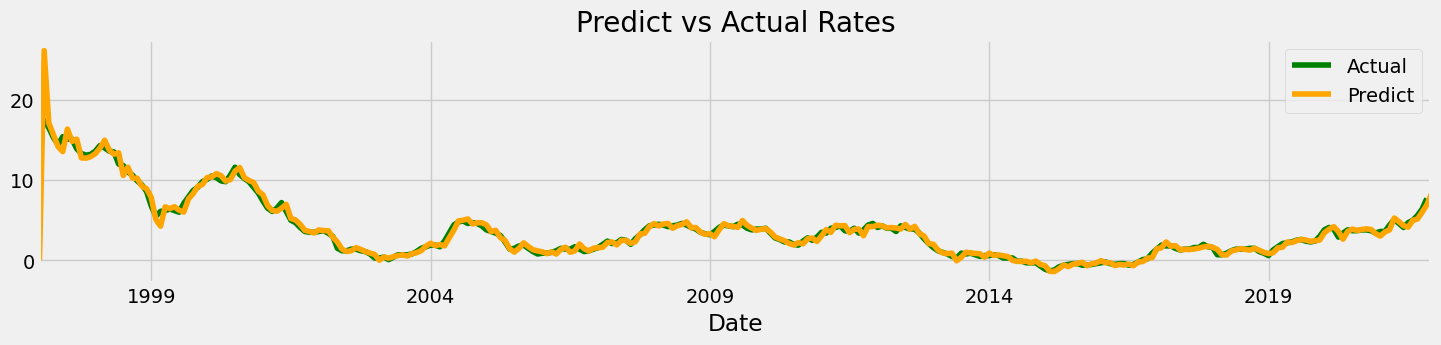

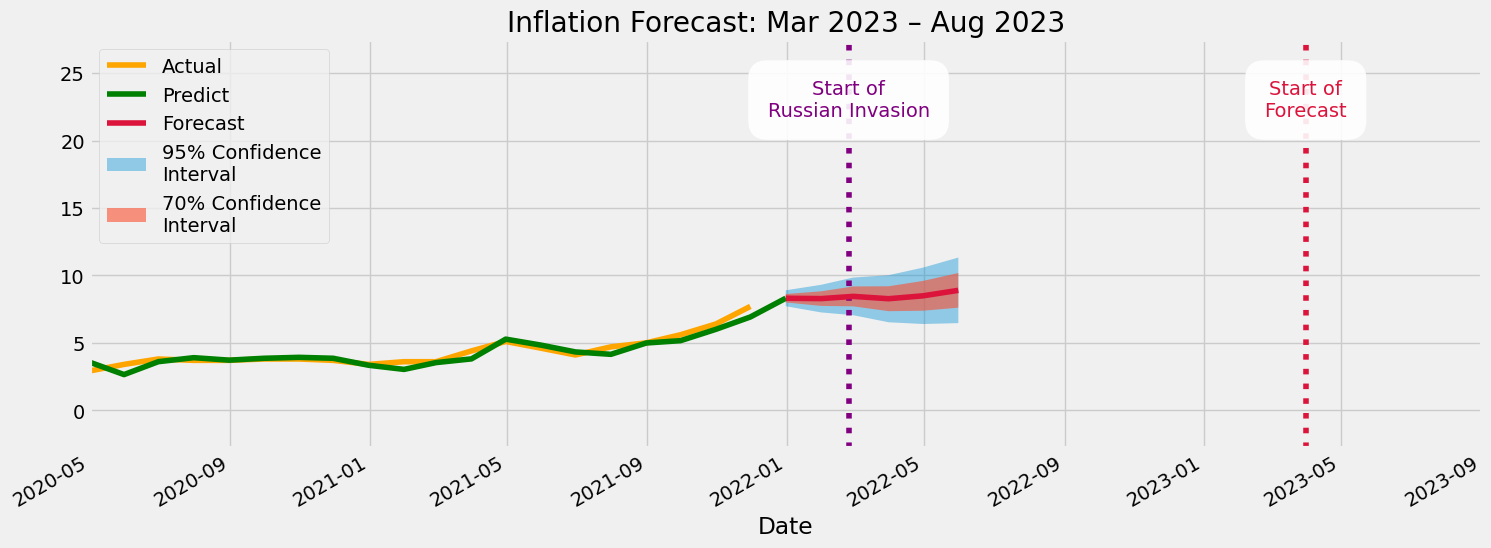

,Forecast [%]
2021-12-31,8.3
2022-01-31,8.3
2022-02-28,8.4
2022-03-31,8.3
2022-04-30,8.5
2022-05-31,8.9


In [20]:
# SARIMA model visualization
def forecast_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    
    # develop model
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, freq='M', exog=exog,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # Save the model
    model_path = '/Users/damodargupta/Desktop/EPICS-PROJECT/sarimax_model.pkl'  
    model_fit.save(model_path)
    
    # predictions (from 0 to February 2023)
    yhat = model_fit.predict(start=0, end=len(series), typ='levels', dynamic=False).rename('Predict')

    # forecast and confidence intervals 70% and 95%
    conf_int_70 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.3)
    conf_int_95 = model_fit.get_forecast(steps=6).summary_frame(alpha=0.05)
    
    # extract index list
    def index_list():
        conf_interval = conf_int_95.reset_index()
        return conf_interval['index'].to_list()

    indx_list = index_list()
    
    # 1st plot - actual vs predict rates
    series.plot(legend=True, label='Actual', figsize=(16, 3), color='green')
    yhat.plot(legend=True, color='orange')
    plt.title('Predict vs Actual Rates')
    plt.legend()
    plt.show()
    
    # list of events to plot
    event_list = [(pd.to_datetime('2022-02-24'), 'Start of\nRussian Invasion', 'purple'),
                  (pd.to_datetime('2023-03-31'), 'Start of\nForecast', 'crimson')]
    
    # plot events
    for date_point, label, clr in event_list:
        plt.axvline(x=date_point, color=clr, linestyle=':')
        plt.text(x=date_point, y=23, s=label, horizontalalignment='center', verticalalignment='center',
                 color=clr, bbox=dict(facecolor='white', alpha=0.9, boxstyle='round, pad=1', linewidth=0.2))

    # 2nd plot - forecasting results
    series.plot(legend=True, label='Actual', figsize=(16, 6), color='orange')
    yhat.plot(legend=True, color='green')
    conf_int_95['mean'].plot(legend=True, label='Forecast', color='crimson')
    # confidence intervals 95%
    plt.fill_between(x=indx_list, y1=conf_int_95['mean_ci_upper'], y2=conf_int_95['mean_ci_lower'],
                     alpha=0.4, label='95% Confidence\nInterval', linewidth=0)
    # confidence intervals 70%
    plt.fill_between(x=indx_list, y1=conf_int_70['mean_ci_upper'], y2=conf_int_70['mean_ci_lower'],
                     alpha=0.6, label='70% Confidence\nInterval', linewidth=0)
    plt.xlim(['2020-05', '2023-09'])
    plt.title('Inflation Forecast: Mar 2023 – Aug 2023')
    plt.legend(loc='upper left')
    plt.show()
    
    # display forecasted rates
    return pd.DataFrame(round(conf_int_95['mean'], 1)).rename({'mean': 'Forecast [%]'}, axis=1)

# plot SARIMA results
forecast_SARIMA(series=df['Rate'], order=(1, 1, 2), seasonal_order=(0, 0, 2, 12))

* The predict spline is fitted to the actual with high accuracy. There are high differences only at the beginning of time series.
* Contrary to what the ruling party says, the Russian invasion of Ukraine did not affect Polish inflation significantly. There are no visible changes in trend.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.86365D-01    |proj g|=  8.78502D-01


 This problem is unconstrained.



At iterate    5    f=  2.33533D-01    |proj g|=  9.59378D-02

At iterate   10    f=  2.22769D-01    |proj g|=  7.73811D-02

At iterate   15    f=  2.15559D-01    |proj g|=  1.86957D-02

At iterate   20    f=  2.15472D-01    |proj g|=  6.88732D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     29      1     0     0   5.173D-06   2.155D-01
  F =  0.21547180822535583     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


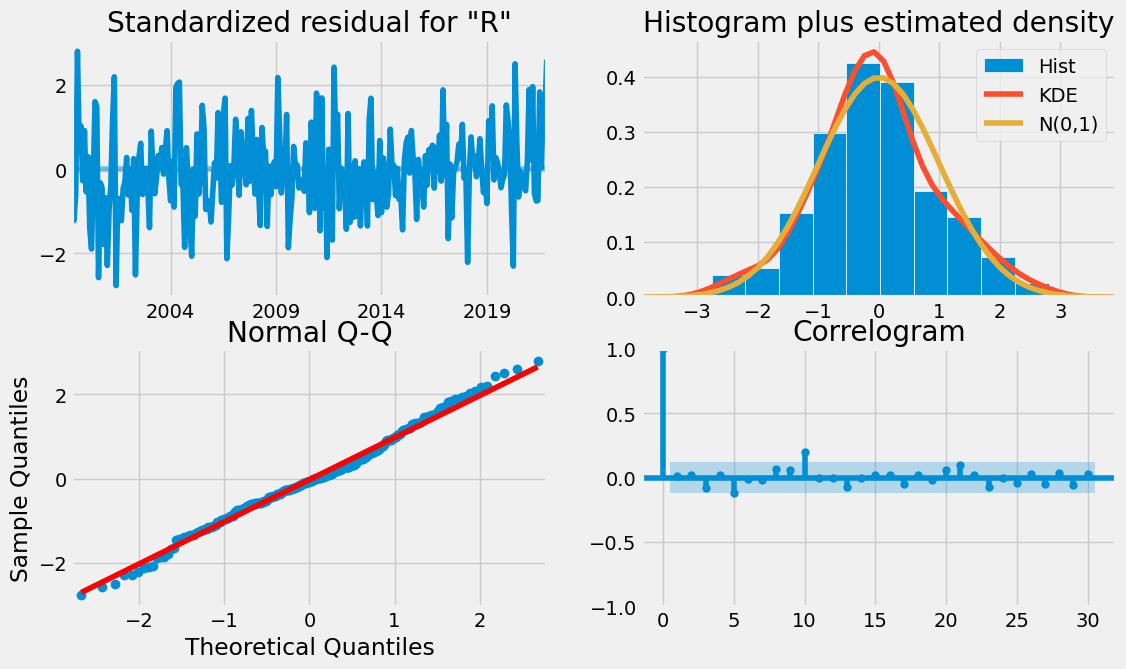

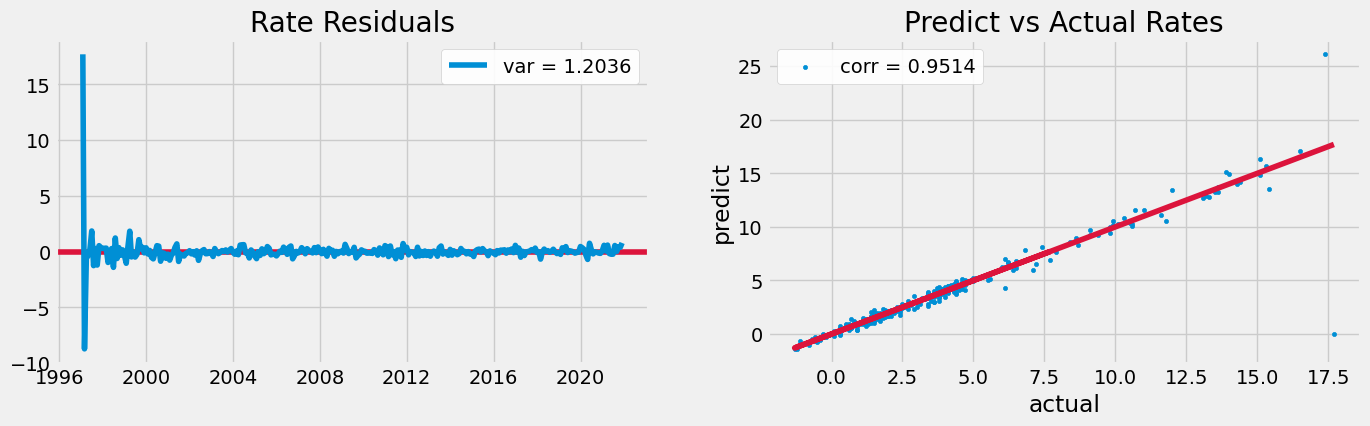

Metric,AIC,BIC,HQIC,RMSE,MAE,MAPE
,140.852141,162.464854,149.52988,1.203817,0.36024,0.157703


In [19]:
# SARIMA model evaluation
def evaluate_SARIMA(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0), exog=None):
    from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
    warnings.simplefilter('ignore', (ConvergenceWarning, ValueWarning))
    from statsmodels.tsa.statespace.sarimax import SARIMAX

    # develop model
    model = SARIMAX(endog=series, order=order, seasonal_order=seasonal_order, freq='M', exog=None,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    
    # predictions
    yhat = model_fit.predict(start=0, end=len(series), typ='levels', dynamic=False)
    
    ######### evaluation scores
    rmse = np.mean((series - yhat[:-1])**2)**0.5
    mae = np.mean(np.abs(series - yhat[:-1]))
    mape = np.mean(np.abs(series - yhat[:-1])/np.abs(series))
    var = np.std(model_fit.resid.values)
    corr = np.corrcoef(series, yhat[:-1])[0, 1]
    
    metric_list = ['AIC', 'BIC', 'HQIC', 'RMSE', 'MAE', 'MAPE']
    value_list = [model_fit.aic, model_fit.bic, model_fit.hqic, rmse, mae, mape]
 
    # 1st plot - diagnostics
    model_fit.plot_diagnostics(lags=30, figsize=(12, 7))
    plt.show()
    
    # 2nd plot - residuals
    fig = plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.axhline(0, color='crimson')
    plt.plot(model_fit.resid, label='var = {:.4f}'.format(var))
    plt.title('Rate Residuals')
    plt.legend(facecolor='white', framealpha=0.9)
    
    # 3rd plot - actual vs predict rates
    plt.subplot(1, 2, 2)
    plt.plot(df['Rate'], df['Rate'], color='crimson')
    plt.scatter(x=df['Rate'], y=yhat[:-1], marker='.', label='corr = {:.4f}'.format(corr))
    plt.title('Predict vs Actual Rates')
    plt.xlabel('actual')
    plt.ylabel('predict')
    plt.legend(facecolor='white', framealpha=0.9)
    plt.show()

    # display evaluation scores
    return pd.DataFrame(zip(metric_list, value_list), columns=['Metric', '']).set_index('Metric').T

# model evaluation
evaluate_SARIMA(series=df['Rate'], order=(1, 1, 2), seasonal_order=(0, 0, 2, 12))

<Axes: >

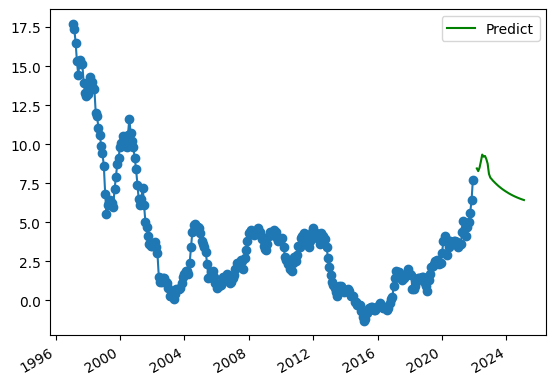

In [16]:
import pandas as pd
import pickle
def get_inflation_rate_range(df, start, end):
    dataframe = pd.read_csv("/Users/damodargupta/Desktop/EPICS-PROJECT/date-wise-data.csv")
    df['Date'] = pd.to_datetime(df['Date'])
    # Create filtered DataFrame
    filtered_df = df[(df['Date'] >= start) & (df['Date'] <= end)]
    plt.plot(filtered_df['Date'], filtered_df['Rate'], marker='o', linestyle='-')

df = pd.read_csv("/Users/damodargupta/Desktop/EPICS-PROJECT/date-wise-data.csv")
get_inflation_rate_range(df, pd.to_datetime("1997-01-31"), pd.to_datetime("2025-01-01"))
model_fit = pickle.load(open("/Users/damodargupta/Desktop/EPICS-PROJECT/sarimax_model.pkl", "rb"))
yhat = model_fit.predict(start=pd.to_datetime("2022-02-28"), end="2025-01-01", typ='levels', dynamic=False).rename('Predict')
yhat.plot(legend=True, color='green')


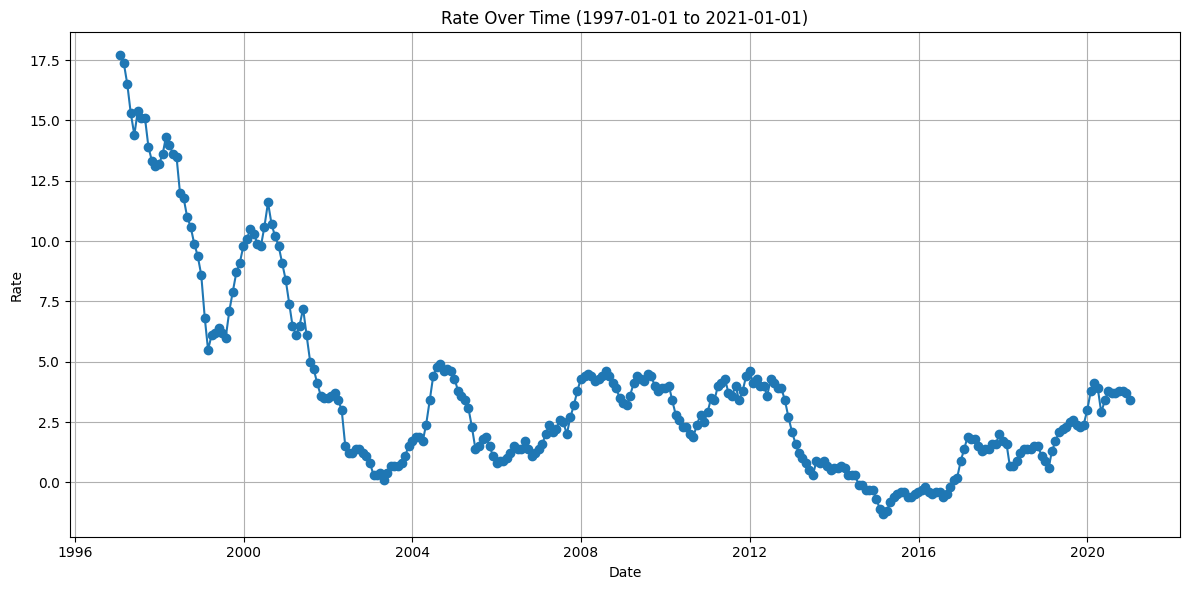

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'df' with 'Date' and 'Rate' columns
# If not, you can create it using:
# df = pd.DataFrame({'Date': ['1997-01-31', '1997-02-28', ..., '2021-11-30'],
#                    'Rate': [17.7, 17.4, ..., 7.7]})
# Make sure to convert the 'Date' column to a datetime type
df['Date'] = pd.to_datetime(df['Date'])

# Select start and end dates
start_date = '1997-01-01'
end_date = '2021-01-01'

# Create filtered DataFrame
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Plotting the filtered data
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Date'], filtered_df['Rate'], marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title(f'Rate Over Time ({start_date} to {end_date})')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()
